# Benchmarking Field Transformations


### DONE - FT-HMC implemented for 8x8 2D QED (using SiLU as activation function).

- [x] Try to minimize size of the force in training. No significant improvements.
- [x]  Some test on ergodicity
- [x] (calculate the probablity of generating the configs obtained via conventional HMC).

### TODO

- [ ] Plot the force size distribution 
- [ ] Is the large force from the original action or Field-Transformation the determinant?
- [ ] If from the determinant, then the fermion force won't cause problem for HMC
- [ ] Use the same Field-Transformation for larger system (say 16x16, 32x32, 64x64, etc)
- [ ] Study how the delta H depends on the system size ( perhaps delta H ~ sqrt(volume) )
- [ ] Study the auto-correlation for observables, topo, plaq, flowed plaq, etc.
- [ ] Improving the Field-Transformation to reduce force.

## Setup, `import`'s, ..., etc

In [1]:
import os
import sys
import torch

from functools import reduce
from IPython.core.interactiveshell import InteractiveShell

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format ='retina'

InteractiveShell.ast_node_interactivity = "all"


project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
import fthmc.utils.io as io
logger = io.Logger()

torch.manual_seed(9)
# torch.set_default_tensor_type(torch.FloatTensor)

#torch.set_num_threads(param.nth)
#torch.set_num_interop_threads(param.nth_interop)
#os.environ["OMP_NUM_THREADS"] = str(param.nth)
#os.environ["KMP_BLOCKTIME"] = "0"
#os.environ["KMP_SETTINGS"] = "1"
#os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

torch.set_default_tensor_type(torch.FloatTensor)

## Specify `Param` object

In [3]:
import matplotlib as mpl

from fthmc.train import train
from fthmc.utils.param import Param
from fthmc.config import TrainConfig, PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_u1_equiv_layers, set_weights
from fthmc.utils.plot_helpers import save_live_plots

import fthmc.utils.qed_helpers as qed

mpl.rcParams['text.usetex'] = False

param = {
    'L': 8,
    'tau': 0.5,
    'nrun': 5,
    'beta': 5.,
    'nstep': 20,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}


train_config = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 1000,
    'n_layers': 32,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})


param = Param(**param)
logger.log(repr(param))

Duplicate key in file PosixPath('/home/foremans/.config/matplotlib/stylelib/dark_jupyter.mplstyle'), line 92 ('figure.facecolor: 474747')
Duplicate key in file PosixPath('/home/foremans/.config/matplotlib/stylelib/dark_jupyter.mplstyle'), line 93 ('figure.edgecolor: 0.50')
In /home/foremans/.config/matplotlib/stylelib/dark_jupyter.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


TORCH DEVICE: cuda


[15:09:11]  Param:                                                                                                                                                                                                                                              
            ----------------                                                                                                                                                                                                                                    
            beta=5.0                                                                                                                                                                                                                                            
            L=8                                                                                                                                                                                                                                                 
            tau=0.5                                                                                                                                                                                                                                             
            nstep=20                                                                                                                                                                                                                                            
            ntraj=256                                                                                                                                                                                                                                           
            nrun=5                                                                                                                                                                                                                                              
            nprint=50                                                                                                                                                                                                                                           
            seed=1331                                                                                                                                                                                                                                           
            randinit=True                                                                                                                                                                                                                                       
            nth=2                                                                                                                                                                                                                                               
            nth_interop=2                                                                                                                                                                                                                                       
            lat=[8, 8]                                                                                                                                                                                                                                          
            nd=2                                                                                                                                                                                                                                                
            shape=[2, 8, 8]                                                                                                                      

## Specify directories for saving model, etc

In [4]:
import datetime

from fthmc.train import run as hmc_run
from fthmc.config import LOGS_DIR

DAYSTR = io.get_timestamp('%Y-%m-%d')
TSTAMP = io.get_timestamp('%Y-%m-%d-%H%M')
NOW = io.get_timestamp('%Y-%m-%d-%H%M%S')

PARAM_DIR = os.path.join(LOGS_DIR, param.uniquestr())
METRICS_DIR = os.path.join(PARAM_DIR, 'metrics')
MODEL_DIR = os.path.join(PARAM_DIR, 'models')
PLOTS_DIR = os.path.join(PARAM_DIR, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR)
io.check_else_make_dir(MODEL_DIR)
io.check_else_make_dir(METRICS_DIR)
io.check_else_make_dir(PLOTS_DIR)

[15:09:11]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20

[15:09:11]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/models

[15:09:11]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/metrics

[15:09:11]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots

In [5]:
fields, metrics = hmc_run(param, logger=logger, keep_fields=True)

hmc_metrics_dir = os.path.join(METRICS_DIR, 'hmc', TSTAMP)
outfile = os.path.join(hmc_metrics_dir, f'hmc_metrics.z')

io.save_history(metrics, outfile, name='hmc_metrics')

[15:09:14]  Param:                                                                                                                                                                                                                                              
            ----------------                                                                                                                                                                                                                                    
            beta=5.0                                                                                                                                                                                                                                            
            L=8                                                                                                                                                                                                                                                 
            tau=0.5                                                                                                                                                                                                                                             
            nstep=20                                                                                                                                                                                                                                            
            ntraj=256                                                                                                                                                                                                                                           
            nrun=5                                                                                                                                                                                                                                              
            nprint=50                                                                                                                                                                                                                                           
            seed=1331                                                                                                                                                                                                                                           
            randinit=True                                                                                                                                                                                                                                       
            nth=2                                                                                                                                                                                                                                               
            nth_interop=2                                                                                                                                                                                                                                       
            lat=[8, 8]                                                                                                                                                                                                                                          
            nd=2                                                                                                                                                                                                                                                
            shape=[2, 8, 8]                                                                                                                      

            action=-0.011 plaq=0.000 charge=3.000

            dt=0.011 traj=2 accept=True dH=0.053 expdH=0.948 dq=1.000

            dt=0.011 traj=7 accept=True dH=-0.020 expdH=1.020 dq=0.000

            dt=0.011 traj=12 accept=True dH=-0.020 expdH=1.020 dq=0.000

            dt=0.011 traj=17 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=22 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=27 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=32 accept=False dH=0.015 expdH=0.985 dq=0.000

            dt=0.011 traj=37 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=42 accept=True dH=0.017 expdH=0.983 dq=0.000

            dt=0.011 traj=47 accept=True dH=-0.015 expdH=1.016 dq=0.000

            dt=0.011 traj=52 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=57 accept=True dH=0.019 expdH=0.982 dq=0.000

            dt=0.011 traj=62 accept=True dH=0.022 expdH=0.978 dq=0.000

[15:09:15]  dt=0.011 traj=67 accept=True dH=0.012 expdH=0.989 dq=0.000

            dt=0.011 traj=72 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=77 accept=True dH=-0.017 expdH=1.018 dq=0.000

            dt=0.011 traj=82 accept=True dH=0.014 expdH=0.987 dq=0.000

            dt=0.011 traj=87 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.015 traj=92 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=97 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=102 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=107 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=112 accept=True dH=0.015 expdH=0.985 dq=0.000

            dt=0.011 traj=117 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=122 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=127 accept=True dH=0.022 expdH=0.978 dq=0.000

            dt=0.011 traj=132 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=137 accept=True dH=-0.016 expdH=1.016 dq=0.000

            dt=0.011 traj=142 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=147 accept=True dH=0.015 expdH=0.985 dq=0.000

[15:09:16]  dt=0.011 traj=152 accept=True dH=-0.001 expdH=1.001 dq=0.000

            dt=0.011 traj=157 accept=True dH=0.031 expdH=0.970 dq=0.000

            dt=0.011 traj=162 accept=True dH=-0.016 expdH=1.016 dq=0.000

            dt=0.011 traj=167 accept=True dH=-0.008 expdH=1.008 dq=0.000

            dt=0.011 traj=172 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=177 accept=True dH=-0.019 expdH=1.019 dq=0.000

            dt=0.011 traj=182 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=187 accept=True dH=-0.001 expdH=1.001 dq=0.000

            dt=0.011 traj=192 accept=True dH=-0.031 expdH=1.031 dq=0.000

            dt=0.011 traj=197 accept=True dH=0.034 expdH=0.967 dq=0.000

            dt=0.011 traj=202 accept=True dH=-0.012 expdH=1.012 dq=0.000

            dt=0.011 traj=207 accept=True dH=0.019 expdH=0.981 dq=0.000

            dt=0.011 traj=212 accept=True dH=0.007 expdH=0.993 dq=0.000

            dt=0.011 traj=217 accept=True dH=0.005 expdH=0.995 dq=0.000

            dt=0.011 traj=222 accept=True dH=0.005 expdH=0.995 dq=0.000

            dt=0.011 traj=227 accept=True dH=0.012 expdH=0.988 dq=0.000

[15:09:17]  dt=0.011 traj=232 accept=True dH=0.016 expdH=0.985 dq=0.000

            dt=0.011 traj=237 accept=True dH=0.029 expdH=0.971 dq=0.000

            dt=0.011 traj=242 accept=True dH=-0.030 expdH=1.030 dq=0.000

            dt=0.011 traj=247 accept=True dH=0.013 expdH=0.987 dq=0.000

            dt=0.011 traj=252 accept=True dH=-0.001 expdH=1.001 dq=0.000

            dt=0.011 traj=258 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=263 accept=True dH=0.005 expdH=0.995 dq=0.000

            dt=0.011 traj=268 accept=True dH=-0.009 expdH=1.009 dq=0.000

            dt=0.011 traj=273 accept=True dH=-0.003 expdH=1.003 dq=0.000

            dt=0.011 traj=278 accept=True dH=0.011 expdH=0.990 dq=0.000

            dt=0.011 traj=283 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=288 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=293 accept=True dH=0.009 expdH=0.991 dq=0.000

            dt=0.011 traj=298 accept=True dH=-0.016 expdH=1.016 dq=0.000

            dt=0.011 traj=303 accept=True dH=0.033 expdH=0.968 dq=0.000

            dt=0.011 traj=308 accept=True dH=-0.004 expdH=1.004 dq=0.000

[15:09:18]  dt=0.011 traj=313 accept=True dH=-0.028 expdH=1.028 dq=0.000

            dt=0.011 traj=318 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=323 accept=True dH=-0.016 expdH=1.017 dq=0.000

            dt=0.011 traj=328 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=333 accept=True dH=0.007 expdH=0.993 dq=0.000

            dt=0.011 traj=338 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=343 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=348 accept=True dH=-0.002 expdH=1.002 dq=0.000

            dt=0.011 traj=353 accept=True dH=-0.018 expdH=1.018 dq=0.000

            dt=0.011 traj=358 accept=True dH=-0.018 expdH=1.018 dq=0.000

            dt=0.011 traj=363 accept=True dH=0.016 expdH=0.984 dq=0.000

            dt=0.011 traj=368 accept=True dH=0.014 expdH=0.986 dq=0.000

            dt=0.011 traj=373 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=378 accept=True dH=-0.015 expdH=1.015 dq=0.000

            dt=0.011 traj=383 accept=True dH=-0.013 expdH=1.013 dq=0.000

            dt=0.011 traj=388 accept=True dH=-0.032 expdH=1.032 dq=0.000

[15:09:19]  dt=0.011 traj=393 accept=True dH=0.005 expdH=0.995 dq=0.000

            dt=0.011 traj=398 accept=True dH=-0.003 expdH=1.003 dq=0.000

            dt=0.011 traj=403 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.011 traj=408 accept=True dH=0.028 expdH=0.973 dq=0.000

            dt=0.011 traj=413 accept=True dH=-0.003 expdH=1.003 dq=0.000

            dt=0.011 traj=418 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=423 accept=True dH=-0.008 expdH=1.008 dq=0.000

            dt=0.011 traj=428 accept=True dH=-0.016 expdH=1.017 dq=0.000

            dt=0.011 traj=433 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=438 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=443 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=448 accept=True dH=-0.017 expdH=1.017 dq=0.000

            dt=0.011 traj=453 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=458 accept=True dH=0.027 expdH=0.974 dq=0.000

            dt=0.011 traj=463 accept=True dH=0.003 expdH=0.997 dq=0.000

            dt=0.011 traj=468 accept=True dH=-0.017 expdH=1.017 dq=0.000

            dt=0.011 traj=473 accept=True dH=0.026 expdH=0.974 dq=0.000

[15:09:20]  dt=0.011 traj=478 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=483 accept=True dH=0.045 expdH=0.956 dq=0.000

            dt=0.011 traj=488 accept=True dH=-0.032 expdH=1.032 dq=0.000

            dt=0.011 traj=493 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.011 traj=498 accept=True dH=0.024 expdH=0.976 dq=0.000

            dt=0.011 traj=503 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=508 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=514 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=519 accept=True dH=-0.013 expdH=1.013 dq=0.000

            dt=0.011 traj=524 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=529 accept=True dH=0.000 expdH=1.000 dq=0.000

            dt=0.011 traj=534 accept=True dH=0.008 expdH=0.993 dq=0.000

            dt=0.011 traj=539 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=544 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=549 accept=True dH=-0.012 expdH=1.013 dq=0.000

            dt=0.011 traj=554 accept=True dH=0.005 expdH=0.995 dq=0.000

[15:09:21]  dt=0.011 traj=559 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=564 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=569 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=574 accept=True dH=-0.023 expdH=1.023 dq=0.000

            dt=0.011 traj=579 accept=True dH=-0.020 expdH=1.021 dq=0.000

            dt=0.011 traj=584 accept=True dH=-0.005 expdH=1.005 dq=0.000

            dt=0.011 traj=589 accept=True dH=0.013 expdH=0.987 dq=0.000

            dt=0.011 traj=594 accept=True dH=-0.022 expdH=1.023 dq=0.000

            dt=0.011 traj=599 accept=True dH=-0.015 expdH=1.015 dq=0.000

            dt=0.011 traj=604 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=609 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=614 accept=True dH=-0.005 expdH=1.005 dq=0.000

            dt=0.011 traj=619 accept=True dH=-0.016 expdH=1.016 dq=0.000

            dt=0.011 traj=624 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=629 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=634 accept=True dH=0.004 expdH=0.996 dq=0.000

[15:09:22]  dt=0.011 traj=639 accept=True dH=-0.026 expdH=1.026 dq=0.000

            dt=0.011 traj=644 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=649 accept=True dH=0.003 expdH=0.997 dq=0.000

            dt=0.011 traj=654 accept=True dH=0.009 expdH=0.991 dq=0.000

            dt=0.011 traj=659 accept=True dH=0.013 expdH=0.987 dq=0.000

            dt=0.011 traj=664 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=669 accept=True dH=0.015 expdH=0.985 dq=0.000

            dt=0.011 traj=674 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=679 accept=True dH=0.018 expdH=0.982 dq=0.000

            dt=0.011 traj=684 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=689 accept=True dH=0.021 expdH=0.979 dq=0.000

            dt=0.011 traj=694 accept=True dH=0.003 expdH=0.997 dq=0.000

            dt=0.011 traj=699 accept=True dH=0.003 expdH=0.997 dq=0.000

            dt=0.011 traj=704 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=709 accept=True dH=-0.005 expdH=1.005 dq=0.000

            dt=0.011 traj=714 accept=True dH=0.006 expdH=0.994 dq=0.000

[15:09:23]  dt=0.011 traj=719 accept=True dH=0.031 expdH=0.969 dq=0.000

            dt=0.011 traj=724 accept=True dH=-0.020 expdH=1.021 dq=0.000

            dt=0.011 traj=729 accept=True dH=0.008 expdH=0.992 dq=0.000

            dt=0.011 traj=734 accept=True dH=-0.018 expdH=1.019 dq=0.000

            dt=0.011 traj=739 accept=True dH=-0.001 expdH=1.001 dq=0.000

            dt=0.011 traj=744 accept=True dH=-0.022 expdH=1.022 dq=0.000

            dt=0.011 traj=749 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=754 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=759 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=764 accept=True dH=0.003 expdH=0.997 dq=0.000

            dt=0.011 traj=770 accept=True dH=-0.012 expdH=1.012 dq=0.000

            dt=0.011 traj=775 accept=True dH=-0.026 expdH=1.026 dq=0.000

            dt=0.011 traj=780 accept=True dH=0.011 expdH=0.989 dq=0.000

            dt=0.011 traj=785 accept=True dH=0.006 expdH=0.994 dq=0.000

            dt=0.011 traj=790 accept=True dH=0.002 expdH=0.998 dq=0.000

            dt=0.011 traj=795 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=800 accept=True dH=-0.003 expdH=1.003 dq=0.000

[15:09:24]  dt=0.011 traj=805 accept=True dH=0.013 expdH=0.988 dq=0.000

            dt=0.011 traj=810 accept=True dH=-0.033 expdH=1.033 dq=0.000

            dt=0.011 traj=815 accept=True dH=0.016 expdH=0.984 dq=0.000

            dt=0.011 traj=820 accept=True dH=-0.008 expdH=1.008 dq=0.000

            dt=0.011 traj=825 accept=True dH=-0.000 expdH=1.000 dq=0.000

            dt=0.011 traj=830 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=835 accept=True dH=0.007 expdH=0.993 dq=0.000

            dt=0.011 traj=840 accept=True dH=-0.037 expdH=1.038 dq=0.000

            dt=0.011 traj=845 accept=True dH=0.002 expdH=0.998 dq=0.000

            dt=0.011 traj=850 accept=True dH=0.005 expdH=0.995 dq=0.000

            dt=0.011 traj=855 accept=True dH=0.030 expdH=0.970 dq=0.000

            dt=0.011 traj=860 accept=True dH=-0.012 expdH=1.012 dq=0.000

            dt=0.011 traj=865 accept=True dH=-0.009 expdH=1.009 dq=0.000

            dt=0.011 traj=870 accept=True dH=0.014 expdH=0.986 dq=0.000

            dt=0.011 traj=875 accept=True dH=0.023 expdH=0.978 dq=0.000

            dt=0.011 traj=880 accept=True dH=0.002 expdH=0.998 dq=0.000

[15:09:25]  dt=0.011 traj=885 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=890 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=895 accept=True dH=-0.009 expdH=1.009 dq=0.000

            dt=0.011 traj=900 accept=True dH=0.018 expdH=0.982 dq=0.000

            dt=0.011 traj=905 accept=True dH=0.009 expdH=0.991 dq=0.000

            dt=0.011 traj=910 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.011 traj=915 accept=True dH=-0.011 expdH=1.011 dq=0.000

            dt=0.011 traj=920 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=925 accept=True dH=-0.010 expdH=1.010 dq=0.000

            dt=0.011 traj=930 accept=True dH=0.029 expdH=0.971 dq=0.000

            dt=0.011 traj=935 accept=True dH=0.009 expdH=0.991 dq=0.000

            dt=0.011 traj=940 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=945 accept=True dH=0.020 expdH=0.980 dq=0.000

            dt=0.011 traj=950 accept=True dH=-0.014 expdH=1.014 dq=0.000

            dt=0.011 traj=955 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=960 accept=True dH=0.012 expdH=0.988 dq=0.000

[15:09:26]  dt=0.011 traj=965 accept=True dH=-0.003 expdH=1.003 dq=0.000

            dt=0.011 traj=970 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=975 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=980 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.011 traj=985 accept=True dH=0.016 expdH=0.984 dq=0.000

            dt=0.011 traj=990 accept=True dH=-0.014 expdH=1.014 dq=0.000

            dt=0.011 traj=995 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=1000 accept=False dH=0.007 expdH=0.993 dq=0.000

            dt=0.011 traj=1005 accept=True dH=-0.017 expdH=1.017 dq=0.000

            dt=0.011 traj=1010 accept=True dH=0.020 expdH=0.980 dq=0.000

            dt=0.011 traj=1015 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=1020 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=1026 accept=True dH=-0.015 expdH=1.015 dq=0.000

            dt=0.011 traj=1031 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=1036 accept=True dH=0.017 expdH=0.983 dq=0.000

            dt=0.011 traj=1041 accept=True dH=-0.005 expdH=1.005 dq=0.000

[15:09:27]  dt=0.011 traj=1046 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=1051 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1056 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=1061 accept=True dH=0.038 expdH=0.963 dq=0.000

            dt=0.011 traj=1066 accept=True dH=0.007 expdH=0.993 dq=0.000

            dt=0.011 traj=1071 accept=True dH=0.015 expdH=0.985 dq=0.000

            dt=0.011 traj=1076 accept=True dH=-0.008 expdH=1.008 dq=0.000

            dt=0.011 traj=1081 accept=True dH=0.028 expdH=0.973 dq=0.000

            dt=0.011 traj=1086 accept=True dH=-0.017 expdH=1.017 dq=0.000

            dt=0.011 traj=1091 accept=True dH=-0.015 expdH=1.015 dq=0.000

            dt=0.011 traj=1096 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=1101 accept=True dH=-0.003 expdH=1.003 dq=0.000

            dt=0.011 traj=1106 accept=True dH=-0.000 expdH=1.000 dq=0.000

            dt=0.011 traj=1111 accept=True dH=-0.022 expdH=1.022 dq=0.000

            dt=0.011 traj=1116 accept=True dH=-0.006 expdH=1.006 dq=0.000

            dt=0.011 traj=1121 accept=True dH=0.010 expdH=0.990 dq=0.000

            dt=0.011 traj=1126 accept=True dH=0.025 expdH=0.975 dq=0.000

[15:09:28]  dt=0.011 traj=1131 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1136 accept=True dH=-0.013 expdH=1.013 dq=0.000

            dt=0.011 traj=1141 accept=True dH=0.012 expdH=0.988 dq=0.000

            dt=0.011 traj=1146 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=1151 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1156 accept=True dH=-0.011 expdH=1.011 dq=0.000

            dt=0.011 traj=1161 accept=True dH=0.022 expdH=0.978 dq=0.000

            dt=0.011 traj=1166 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1171 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1176 accept=True dH=0.002 expdH=0.998 dq=0.000

            dt=0.011 traj=1181 accept=True dH=-0.000 expdH=1.000 dq=0.000

            dt=0.011 traj=1186 accept=True dH=-0.002 expdH=1.002 dq=0.000

            dt=0.011 traj=1191 accept=True dH=-0.002 expdH=1.002 dq=0.000

            dt=0.011 traj=1196 accept=True dH=-0.030 expdH=1.031 dq=0.000

            dt=0.011 traj=1201 accept=True dH=-0.002 expdH=1.002 dq=0.000

            dt=0.011 traj=1206 accept=True dH=0.005 expdH=0.995 dq=0.000

[15:09:29]  dt=0.011 traj=1211 accept=True dH=0.031 expdH=0.970 dq=0.000

            dt=0.011 traj=1216 accept=True dH=-0.002 expdH=1.002 dq=0.000

            dt=0.011 traj=1221 accept=True dH=-0.004 expdH=1.004 dq=0.000

            dt=0.011 traj=1226 accept=True dH=0.004 expdH=0.996 dq=0.000

            dt=0.011 traj=1231 accept=True dH=0.038 expdH=0.963 dq=0.000

            dt=0.011 traj=1236 accept=True dH=-0.007 expdH=1.007 dq=0.000

            dt=0.011 traj=1241 accept=True dH=-0.022 expdH=1.022 dq=0.000

            dt=0.011 traj=1246 accept=True dH=-0.018 expdH=1.018 dq=0.000

            dt=0.011 traj=1251 accept=True dH=0.001 expdH=0.999 dq=0.000

            dt=0.011 traj=1256 accept=True dH=-0.021 expdH=1.022 dq=0.000

            dt=0.011 traj=1261 accept=True dH=0.022 expdH=0.979 dq=0.000

            dt=0.011 traj=1266 accept=True dH=-0.032 expdH=1.033 dq=0.000

            dt=0.011 traj=1271 accept=True dH=-0.008 expdH=1.008 dq=0.000

            dt=0.011 traj=1276 accept=True dH=-0.006 expdH=1.006 dq=0.000

            Run times: [0.010897, 3.147717, 0.010828, 3.133992, 0.010845, 3.134531, 0.010802, 3.13779, 0.01089, 3.14281]

            Per trajectory: [4.3e-05, 0.012296, 4.2e-05, 0.012242, 4.2e-05, 0.012244, 4.2e-05, 0.012257, 4.3e-05, 0.012277]

[15:09:29]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/metrics/hmc/2021-05-25-1509

[15:09:29]  Saving hmc_metrics to /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/metrics/hmc/2021-05-25-1509/hmc_metrics.z.

## Specify `TrainConfig` object for training our model

Note, we train the `pre_flow_model` using the Kullback-Leibler divergence:

$$
D_{\mathrm{KL}} = \left(P\|Q\right) = \sum_{x\in\mathcal{X}} P(x)\log\left(\frac{P(x)}{Q(x)}\right)
$$

## Define `TrainConfig` and build model as
```python
model = {
    'prior': MultivariateUniform(...),
    'model': make_u1_equiv_layers(...),
}
```

### Train `model_init`:

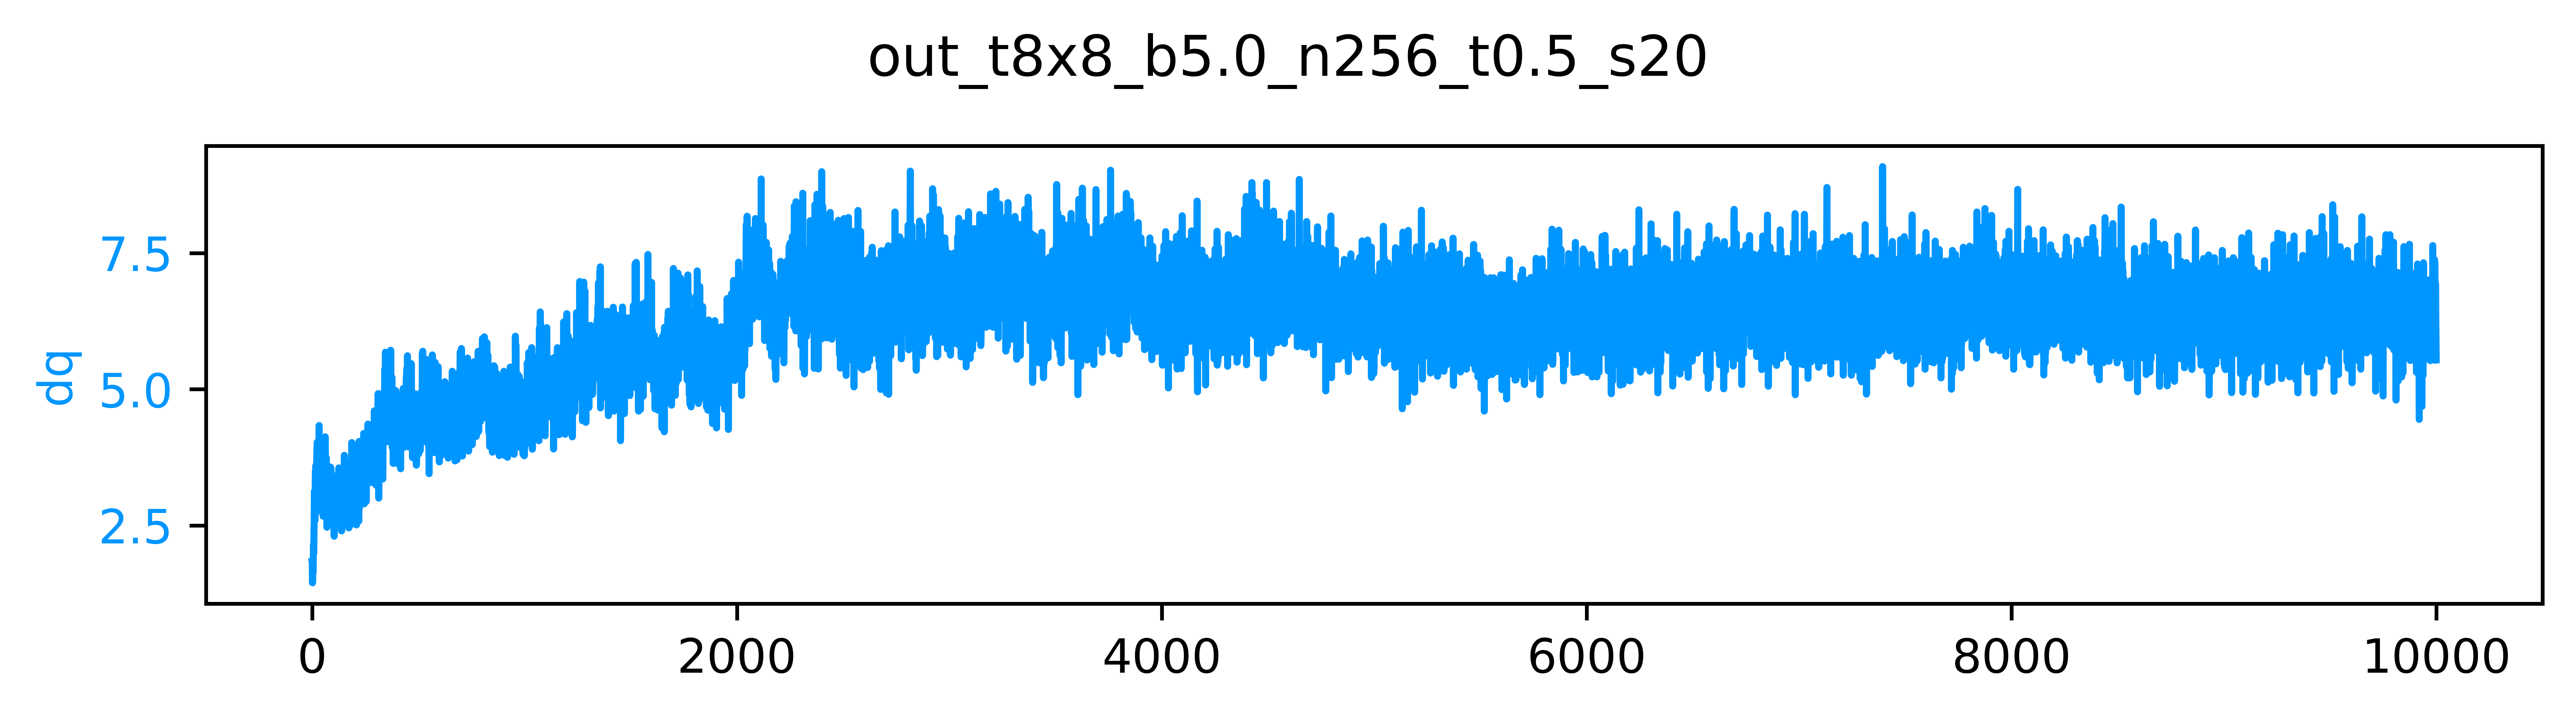

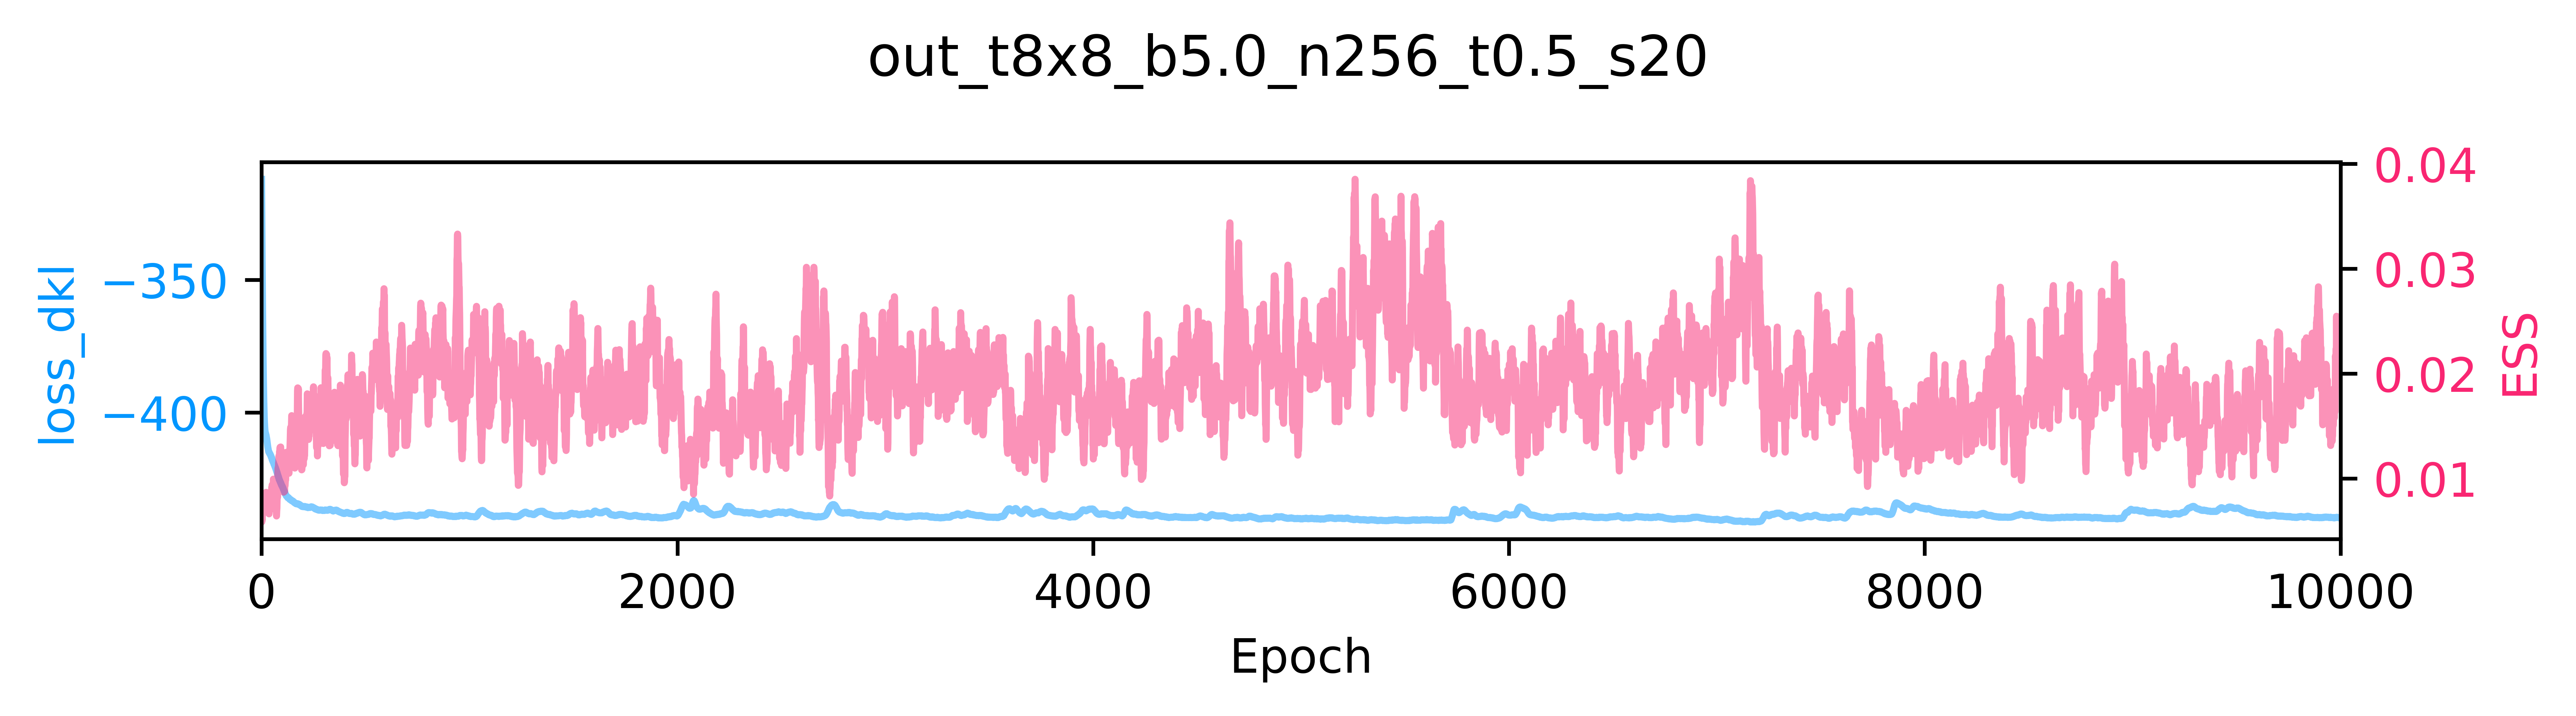

[15:10:47]  ---------------------------------------                                                                                                                                                                                                             
            ERA=0, last took: 0 min 0 s                                                                                                                                                                                                                         
            ---------------------------------------

[15:11:25]  epoch=97.000 dt=0.159 loss=-426.588 dq=3.14297 ess=0.0106267 action=0.815622 loss_dkl=-426.588 logp=260.999 logq=-165.59

[15:11:43]  epoch=197.000 dt=0.163 loss=-435.137 dq=2.98203 ess=0.00906199 action=0.848677 loss_dkl=-435.137 logp=271.577 logq=-163.56

[15:12:01]  epoch=297.000 dt=0.160 loss=-436.746 dq=3.98828 ess=0.019128 action=0.85705 loss_dkl=-436.746 logp=274.256 logq=-162.49

[15:12:19]  epoch=397.000 dt=0.162 loss=-437.73 dq=4.48828 ess=0.0117228 action=0.863536 loss_dkl=-437.730 logp=276.331 logq=-161.398

[15:12:37]  epoch=497.000 dt=0.162 loss=-438.439 dq=4.43594 ess=0.0224006 action=0.862388 loss_dkl=-438.439 logp=275.964 logq=-162.475

[15:12:55]  epoch=597.000 dt=0.163 loss=-438.408 dq=4.39141 ess=0.0176028 action=0.857843 loss_dkl=-438.408 logp=274.51 logq=-163.898

[15:13:13]  epoch=697.000 dt=0.161 loss=-438.537 dq=4.98438 ess=0.0142043 action=0.868973 loss_dkl=-438.537 logp=278.071 logq=-160.466

[15:13:32]  epoch=797.000 dt=0.179 loss=-438.725 dq=5.05312 ess=0.032786 action=0.863504 loss_dkl=-438.724 logp=276.321 logq=-162.403

[15:13:50]  epoch=897.000 dt=0.163 loss=-438.478 dq=4.775 ess=0.0330551 action=0.868116 loss_dkl=-438.478 logp=277.797 logq=-160.681

[15:14:08]  epoch=997.000 dt=0.181 loss=-438.944 dq=4.51172 ess=0.0314317 action=0.863672 loss_dkl=-438.944 logp=276.375 logq=-162.569

[15:14:10]  ---------------------------------------                                                                                                                                                                                                             
            ERA=1, last took: 3 min 23 s                                                                                                                                                                                                                        
            ---------------------------------------

[15:14:27]  epoch=97.000 dt=0.163 loss=-438.327 dq=4.99687 ess=0.0152727 action=0.860071 loss_dkl=-438.327 logp=275.223 logq=-163.104

[15:14:45]  epoch=197.000 dt=0.164 loss=-439.005 dq=5.23906 ess=0.0265409 action=0.867393 loss_dkl=-439.005 logp=277.566 logq=-161.439

[15:15:03]  epoch=297.000 dt=0.161 loss=-438.034 dq=5.77266 ess=0.0151772 action=0.865004 loss_dkl=-438.034 logp=276.801 logq=-161.232

[15:15:22]  epoch=397.000 dt=0.163 loss=-438.457 dq=5.50859 ess=0.00999817 action=0.865643 loss_dkl=-438.457 logp=277.006 logq=-161.451

[15:15:40]  epoch=497.000 dt=0.164 loss=-437.896 dq=5.27344 ess=0.017281 action=0.870261 loss_dkl=-437.896 logp=278.484 logq=-159.413

[15:15:59]  epoch=597.000 dt=0.164 loss=-438.513 dq=5.80781 ess=0.0241511 action=0.869025 loss_dkl=-438.513 logp=278.088 logq=-160.425

[15:16:17]  epoch=697.000 dt=0.172 loss=-438.568 dq=5.54141 ess=0.0158573 action=0.864781 loss_dkl=-438.568 logp=276.73 logq=-161.838

[15:16:36]  epoch=797.000 dt=0.167 loss=-438.92 dq=5.61172 ess=0.0185031 action=0.867248 loss_dkl=-438.920 logp=277.519 logq=-161.401

[15:16:55]  epoch=897.000 dt=0.165 loss=-439.547 dq=5.35547 ess=0.0279185 action=0.867676 loss_dkl=-439.547 logp=277.656 logq=-161.891

[15:17:13]  epoch=997.000 dt=0.169 loss=-438.884 dq=5.70859 ess=0.0176729 action=0.869183 loss_dkl=-438.884 logp=278.138 logq=-160.746

[15:17:15]  ---------------------------------------                                                                                                                                                                                                             
            ERA=2, last took: 3 min 5.003 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:17:32]  epoch=97.000 dt=0.167 loss=-435.287 dq=7.20312 ess=0.00939514 action=0.859055 loss_dkl=-435.287 logp=274.898 logq=-160.389

[15:17:51]  epoch=197.000 dt=0.172 loss=-438.348 dq=6.27578 ess=0.0193157 action=0.8634 loss_dkl=-438.348 logp=276.288 logq=-162.061

[15:18:10]  epoch=297.000 dt=0.172 loss=-437.34 dq=7.20078 ess=0.0169898 action=0.866755 loss_dkl=-437.340 logp=277.361 logq=-159.979

[15:18:29]  epoch=397.000 dt=0.171 loss=-438.392 dq=7.56016 ess=0.0222001 action=0.868914 loss_dkl=-438.392 logp=278.052 logq=-160.339

[15:18:48]  epoch=497.000 dt=0.170 loss=-437.405 dq=6.76797 ess=0.0142288 action=0.869998 loss_dkl=-437.405 logp=278.399 logq=-159.005

[15:19:07]  epoch=597.000 dt=0.167 loss=-438.445 dq=6.59297 ess=0.013572 action=0.871145 loss_dkl=-438.445 logp=278.766 logq=-159.679

[15:19:26]  epoch=697.000 dt=0.168 loss=-439.298 dq=6.57812 ess=0.0146901 action=0.87167 loss_dkl=-439.298 logp=278.934 logq=-160.364

[15:19:45]  epoch=797.000 dt=0.167 loss=-437.797 dq=6.87734 ess=0.0209876 action=0.86546 loss_dkl=-437.797 logp=276.947 logq=-160.85

[15:20:04]  epoch=897.000 dt=0.171 loss=-438.835 dq=7.32266 ess=0.0288546 action=0.866476 loss_dkl=-438.835 logp=277.272 logq=-161.563

[15:20:23]  epoch=997.000 dt=0.168 loss=-438.947 dq=6.74453 ess=0.0293504 action=0.864275 loss_dkl=-438.947 logp=276.568 logq=-162.378

[15:20:24]  ---------------------------------------                                                                                                                                                                                                             
            ERA=3, last took: 3 min 9.21 s                                                                                                                                                                                                                      
            ---------------------------------------

[15:20:42]  epoch=97.000 dt=0.168 loss=-439.264 dq=6.35469 ess=0.0212373 action=0.86616 loss_dkl=-439.264 logp=277.171 logq=-162.093

[15:21:01]  epoch=197.000 dt=0.169 loss=-439.267 dq=6.96562 ess=0.0140332 action=0.865913 loss_dkl=-439.267 logp=277.092 logq=-162.175

[15:21:20]  epoch=297.000 dt=0.169 loss=-439.368 dq=6.71484 ess=0.0135864 action=0.867015 loss_dkl=-439.368 logp=277.445 logq=-161.924

[15:21:38]  epoch=397.000 dt=0.167 loss=-437.927 dq=6.96562 ess=0.0137041 action=0.869662 loss_dkl=-437.927 logp=278.292 logq=-159.635

[15:21:57]  epoch=497.000 dt=0.166 loss=-439.542 dq=6.61328 ess=0.0222766 action=0.871077 loss_dkl=-439.542 logp=278.745 logq=-160.797

[15:22:16]  epoch=597.000 dt=0.168 loss=-436.65 dq=6.78359 ess=0.0126846 action=0.873462 loss_dkl=-436.650 logp=279.508 logq=-157.142

[15:22:34]  epoch=697.000 dt=0.166 loss=-436.928 dq=6.825 ess=0.0154163 action=0.871368 loss_dkl=-436.928 logp=278.838 logq=-158.091

[15:22:53]  epoch=797.000 dt=0.166 loss=-438.664 dq=6.6625 ess=0.0269485 action=0.871463 loss_dkl=-438.664 logp=278.868 logq=-159.795

[15:23:12]  epoch=897.000 dt=0.166 loss=-439.496 dq=6.63438 ess=0.0230785 action=0.87122 loss_dkl=-439.496 logp=278.79 logq=-160.706

[15:23:31]  epoch=997.000 dt=0.166 loss=-436.468 dq=6.62422 ess=0.0261981 action=0.868669 loss_dkl=-436.468 logp=277.974 logq=-158.493

[15:23:32]  ---------------------------------------                                                                                                                                                                                                             
            ERA=4, last took: 3 min 8.072 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:23:49]  epoch=97.000 dt=0.167 loss=-438.785 dq=7.05703 ess=0.0156785 action=0.871451 loss_dkl=-438.785 logp=278.864 logq=-159.921

[15:24:08]  epoch=197.000 dt=0.168 loss=-438.21 dq=6.65391 ess=0.0217832 action=0.871014 loss_dkl=-438.210 logp=278.724 logq=-159.486

[15:24:27]  epoch=297.000 dt=0.167 loss=-438.952 dq=6.47891 ess=0.019797 action=0.872523 loss_dkl=-438.952 logp=279.207 logq=-159.745

[15:24:46]  epoch=397.000 dt=0.167 loss=-439.427 dq=6.77969 ess=0.0185284 action=0.871655 loss_dkl=-439.427 logp=278.93 logq=-160.497

[15:25:05]  epoch=497.000 dt=0.168 loss=-439.558 dq=7.02578 ess=0.0205385 action=0.872177 loss_dkl=-439.558 logp=279.097 logq=-160.462

[15:25:23]  epoch=597.000 dt=0.168 loss=-438.954 dq=6.80625 ess=0.01911 action=0.871139 loss_dkl=-438.954 logp=278.764 logq=-160.19

[15:25:42]  epoch=697.000 dt=0.176 loss=-439.625 dq=6.95625 ess=0.0156106 action=0.872751 loss_dkl=-439.625 logp=279.28 logq=-160.345

[15:26:01]  epoch=797.000 dt=0.167 loss=-439.857 dq=6.75391 ess=0.0196592 action=0.874653 loss_dkl=-439.857 logp=279.889 logq=-159.969

[15:26:20]  epoch=897.000 dt=0.167 loss=-439.299 dq=6.32109 ess=0.0158773 action=0.868775 loss_dkl=-439.299 logp=278.008 logq=-161.291

[15:26:39]  epoch=997.000 dt=0.167 loss=-439.816 dq=6.04453 ess=0.0162656 action=0.869404 loss_dkl=-439.816 logp=278.209 logq=-161.607

[15:26:41]  ---------------------------------------                                                                                                                                                                                                             
            ERA=5, last took: 3 min 8.431 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:26:58]  epoch=97.000 dt=0.169 loss=-440.286 dq=6.27422 ess=0.0196279 action=0.870475 loss_dkl=-440.286 logp=278.552 logq=-161.734

[15:27:17]  epoch=197.000 dt=0.168 loss=-439.891 dq=7.06016 ess=0.0212246 action=0.866441 loss_dkl=-439.891 logp=277.261 logq=-162.63

[15:27:36]  epoch=297.000 dt=0.169 loss=-440.443 dq=6.48672 ess=0.0237147 action=0.869043 loss_dkl=-440.443 logp=278.094 logq=-162.349

[15:27:55]  epoch=397.000 dt=0.168 loss=-440.584 dq=6.5 ess=0.0206569 action=0.869397 loss_dkl=-440.584 logp=278.207 logq=-162.377

[15:28:14]  epoch=497.000 dt=0.168 loss=-440.767 dq=6.40859 ess=0.0241566 action=0.872752 loss_dkl=-440.767 logp=279.28 logq=-161.486

[15:28:33]  epoch=597.000 dt=0.171 loss=-440.538 dq=6.65859 ess=0.0208964 action=0.870722 loss_dkl=-440.538 logp=278.631 logq=-161.907

[15:28:52]  epoch=697.000 dt=0.172 loss=-440.732 dq=6.33125 ess=0.0152527 action=0.873343 loss_dkl=-440.732 logp=279.47 logq=-161.262

[15:29:11]  epoch=797.000 dt=0.168 loss=-436.979 dq=6.13828 ess=0.0140311 action=0.876554 loss_dkl=-436.979 logp=280.497 logq=-156.481

[15:29:31]  epoch=897.000 dt=0.170 loss=-439.35 dq=6.19219 ess=0.0194484 action=0.873545 loss_dkl=-439.350 logp=279.534 logq=-159.815

[15:29:50]  epoch=997.000 dt=0.170 loss=-438.336 dq=6.13594 ess=0.0131264 action=0.877908 loss_dkl=-438.336 logp=280.931 logq=-157.405

[15:29:52]  ---------------------------------------                                                                                                                                                                                                             
            ERA=6, last took: 3 min 10.87 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:30:09]  epoch=97.000 dt=0.187 loss=-437.473 dq=6.42734 ess=0.0119575 action=0.873138 loss_dkl=-437.473 logp=279.404 logq=-158.069

[15:30:29]  epoch=197.000 dt=0.171 loss=-439.565 dq=6.16563 ess=0.0165349 action=0.873827 loss_dkl=-439.565 logp=279.625 logq=-159.94

[15:30:49]  epoch=297.000 dt=0.173 loss=-439.291 dq=6.21562 ess=0.024835 action=0.877716 loss_dkl=-439.291 logp=280.869 logq=-158.421

[15:31:08]  epoch=397.000 dt=0.170 loss=-439.258 dq=6.68516 ess=0.0131954 action=0.875964 loss_dkl=-439.258 logp=280.308 logq=-158.95

[15:31:27]  epoch=497.000 dt=0.170 loss=-439.215 dq=6.17812 ess=0.018908 action=0.876285 loss_dkl=-439.215 logp=280.411 logq=-158.804

[15:31:46]  epoch=597.000 dt=0.176 loss=-439.702 dq=6.58828 ess=0.0198997 action=0.876307 loss_dkl=-439.702 logp=280.418 logq=-159.284

[15:32:06]  epoch=697.000 dt=0.170 loss=-439.744 dq=6.43594 ess=0.0186533 action=0.876484 loss_dkl=-439.744 logp=280.475 logq=-159.27

[15:32:25]  epoch=797.000 dt=0.169 loss=-440.33 dq=6.87422 ess=0.0186627 action=0.875727 loss_dkl=-440.330 logp=280.232 logq=-160.097

[15:32:45]  epoch=897.000 dt=0.173 loss=-439.71 dq=6.21406 ess=0.0172639 action=0.879077 loss_dkl=-439.710 logp=281.305 logq=-158.405

[15:33:04]  epoch=997.000 dt=0.170 loss=-440.511 dq=6.48438 ess=0.0288228 action=0.877824 loss_dkl=-440.511 logp=280.904 logq=-159.607

[15:33:06]  ---------------------------------------                                                                                                                                                                                                             
            ERA=7, last took: 3 min 14.09 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:33:23]  epoch=97.000 dt=0.171 loss=-440.878 dq=6.37656 ess=0.0194475 action=0.874496 loss_dkl=-440.878 logp=279.839 logq=-161.039

[15:33:43]  epoch=197.000 dt=0.172 loss=-441.282 dq=6.34375 ess=0.0146529 action=0.877591 loss_dkl=-441.282 logp=280.829 logq=-160.453

[15:34:03]  epoch=297.000 dt=0.170 loss=-438.007 dq=5.73438 ess=0.0131906 action=0.87788 loss_dkl=-438.007 logp=280.922 logq=-157.085

[15:34:22]  epoch=397.000 dt=0.171 loss=-439.712 dq=6.43359 ess=0.0274201 action=0.877624 loss_dkl=-439.712 logp=280.84 logq=-158.872

[15:34:41]  epoch=497.000 dt=0.169 loss=-439.287 dq=7.09062 ess=0.0249569 action=0.874426 loss_dkl=-439.287 logp=279.816 logq=-159.471

[15:35:01]  epoch=597.000 dt=0.171 loss=-439.439 dq=7.20391 ess=0.0247414 action=0.872563 loss_dkl=-439.439 logp=279.22 logq=-160.218

[15:35:20]  epoch=697.000 dt=0.189 loss=-437.588 dq=6.33516 ess=0.0162706 action=0.87245 loss_dkl=-437.588 logp=279.184 logq=-158.404

[15:35:40]  epoch=797.000 dt=0.171 loss=-437.564 dq=6.73047 ess=0.019466 action=0.871635 loss_dkl=-437.564 logp=278.923 logq=-158.641

[15:36:00]  epoch=897.000 dt=0.172 loss=-435.123 dq=6.81172 ess=0.0130024 action=0.866546 loss_dkl=-435.123 logp=277.295 logq=-157.829

[15:36:20]  epoch=997.000 dt=0.171 loss=-436.432 dq=6.41563 ess=0.0146799 action=0.874551 loss_dkl=-436.432 logp=279.857 logq=-156.575

[15:36:22]  ---------------------------------------                                                                                                                                                                                                             
            ERA=8, last took: 3 min 15.78 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:36:39]  epoch=97.000 dt=0.170 loss=-437.74 dq=6.4 ess=0.0202452 action=0.873747 loss_dkl=-437.740 logp=279.599 logq=-158.141

[15:36:59]  epoch=197.000 dt=0.190 loss=-438.467 dq=6.74922 ess=0.0208585 action=0.872976 loss_dkl=-438.467 logp=279.352 logq=-159.115

[15:37:18]  epoch=297.000 dt=0.171 loss=-438.323 dq=6.32812 ess=0.0192642 action=0.874367 loss_dkl=-438.323 logp=279.797 logq=-158.525

[15:37:38]  epoch=397.000 dt=0.169 loss=-439.259 dq=6.64766 ess=0.0218693 action=0.873286 loss_dkl=-439.259 logp=279.451 logq=-159.808

[15:37:58]  epoch=497.000 dt=0.171 loss=-438.893 dq=6.61016 ess=0.0180249 action=0.877121 loss_dkl=-438.893 logp=280.679 logq=-158.215

[15:38:17]  epoch=597.000 dt=0.171 loss=-439.884 dq=6.3125 ess=0.0293588 action=0.87483 loss_dkl=-439.884 logp=279.945 logq=-159.938

[15:38:38]  epoch=697.000 dt=0.180 loss=-439.411 dq=6.29688 ess=0.0135357 action=0.875541 loss_dkl=-439.411 logp=280.173 logq=-159.238

[15:38:58]  epoch=797.000 dt=0.189 loss=-439.45 dq=6.33125 ess=0.020647 action=0.875687 loss_dkl=-439.450 logp=280.22 logq=-159.23

[15:39:18]  epoch=897.000 dt=0.171 loss=-439.996 dq=6.57031 ess=0.0222253 action=0.877596 loss_dkl=-439.996 logp=280.831 logq=-159.165

[15:39:37]  epoch=997.000 dt=0.171 loss=-436.494 dq=6.65 ess=0.0141907 action=0.873528 loss_dkl=-436.494 logp=279.529 logq=-156.965

[15:39:40]  ---------------------------------------                                                                                                                                                                                                             
            ERA=9, last took: 3 min 17.91 s                                                                                                                                                                                                                     
            ---------------------------------------

[15:39:58]  epoch=97.000 dt=0.177 loss=-437.757 dq=5.91484 ess=0.015797 action=0.878823 loss_dkl=-437.757 logp=281.223 logq=-156.533

[15:40:17]  epoch=197.000 dt=0.172 loss=-438.108 dq=6.46719 ess=0.0157315 action=0.875905 loss_dkl=-438.108 logp=280.289 logq=-157.819

[15:40:37]  epoch=297.000 dt=0.173 loss=-435.409 dq=6.57188 ess=0.00958606 action=0.877889 loss_dkl=-435.409 logp=280.924 logq=-154.484

[15:40:57]  epoch=397.000 dt=0.174 loss=-437.129 dq=6.76016 ess=0.0155969 action=0.873857 loss_dkl=-437.129 logp=279.634 logq=-157.495

[15:41:17]  epoch=497.000 dt=0.174 loss=-436.368 dq=6.425 ess=0.0126484 action=0.873156 loss_dkl=-436.368 logp=279.41 logq=-156.958

[15:41:36]  epoch=597.000 dt=0.171 loss=-438.095 dq=6.64844 ess=0.0187365 action=0.874496 loss_dkl=-438.095 logp=279.839 logq=-158.256

[15:41:56]  epoch=697.000 dt=0.171 loss=-438.897 dq=6.81016 ess=0.0116571 action=0.878091 loss_dkl=-438.897 logp=280.989 logq=-157.908

[15:42:16]  epoch=797.000 dt=0.174 loss=-439.457 dq=7.01953 ess=0.0126466 action=0.875732 loss_dkl=-439.457 logp=280.234 logq=-159.223

[15:42:35]  epoch=897.000 dt=0.174 loss=-439.54 dq=6.55625 ess=0.0355225 action=0.879985 loss_dkl=-439.540 logp=281.595 logq=-157.944

[15:42:55]  epoch=997.000 dt=0.174 loss=-439.528 dq=6.06484 ess=0.0219886 action=0.878595 loss_dkl=-439.528 logp=281.15 logq=-158.377

[15:42:57]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/models/pre_flow_model/2021-05-25-1509

[15:42:57]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/models/pre_flow_model/2021-05-25-1509/pre_flow_model.tar

[15:42:58]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509

[15:42:58]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/dq_training.pdf

[15:42:59]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/loss_dkl_ess_training.pdf

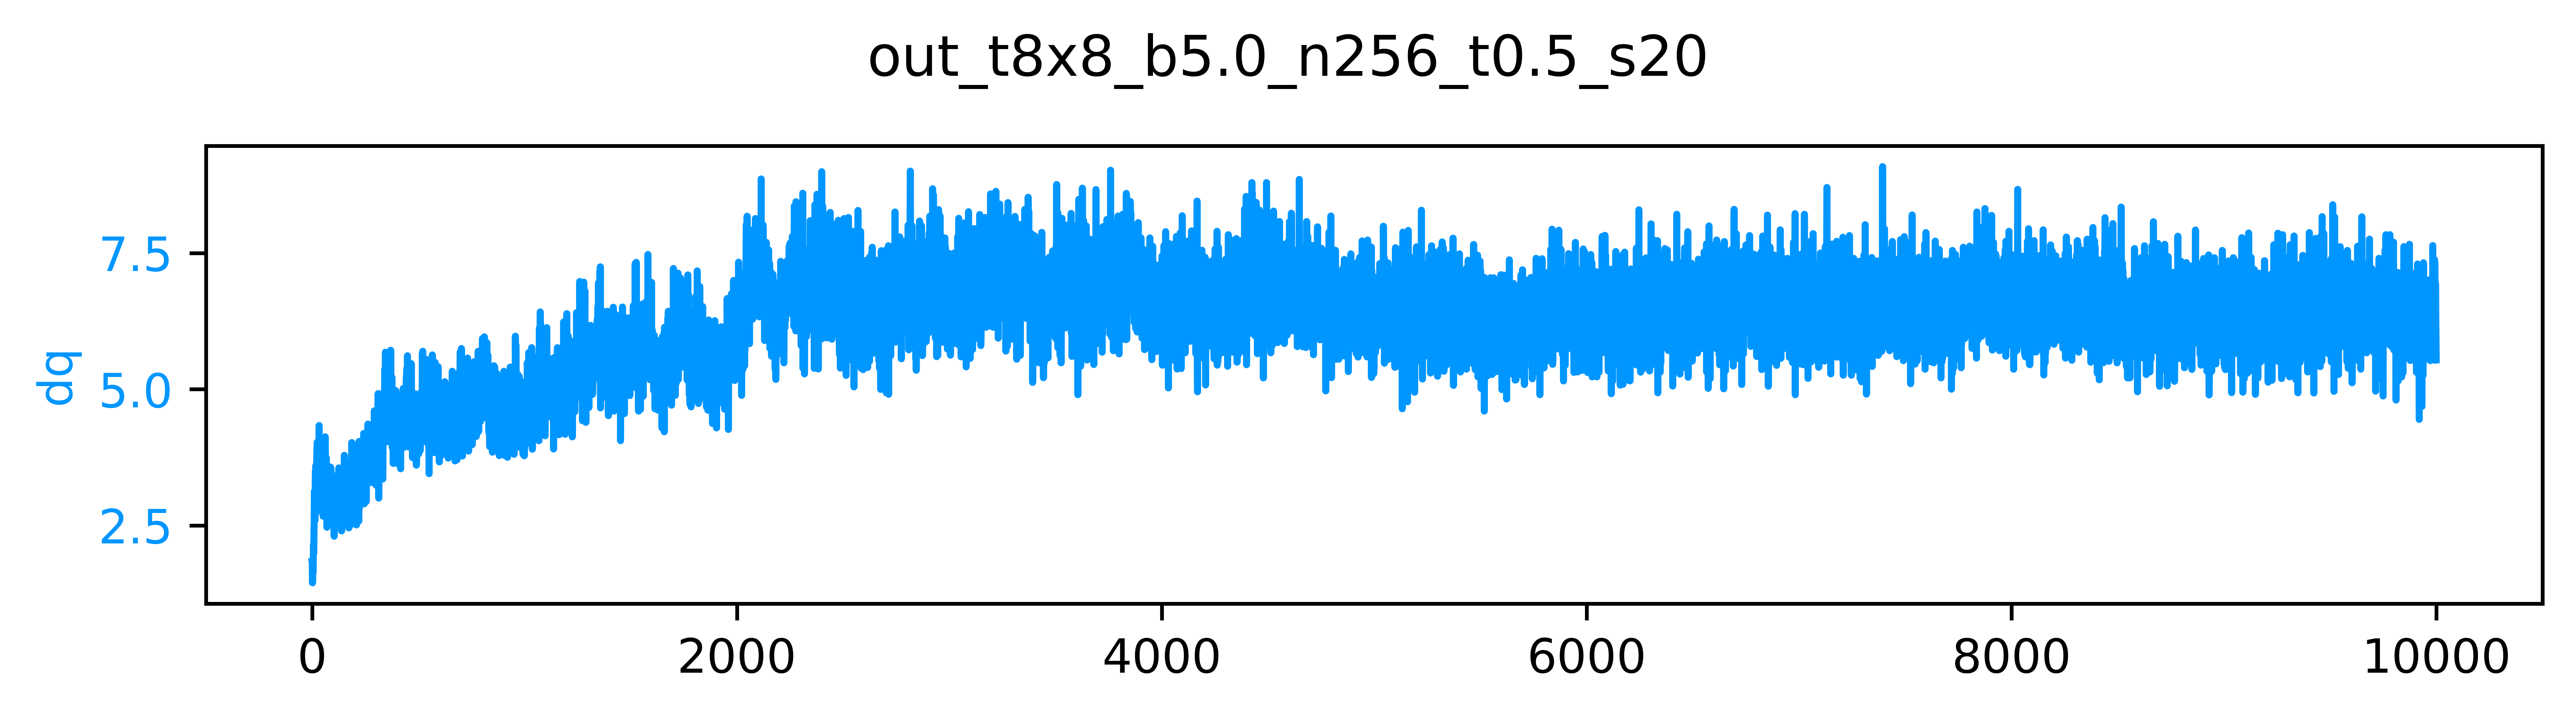

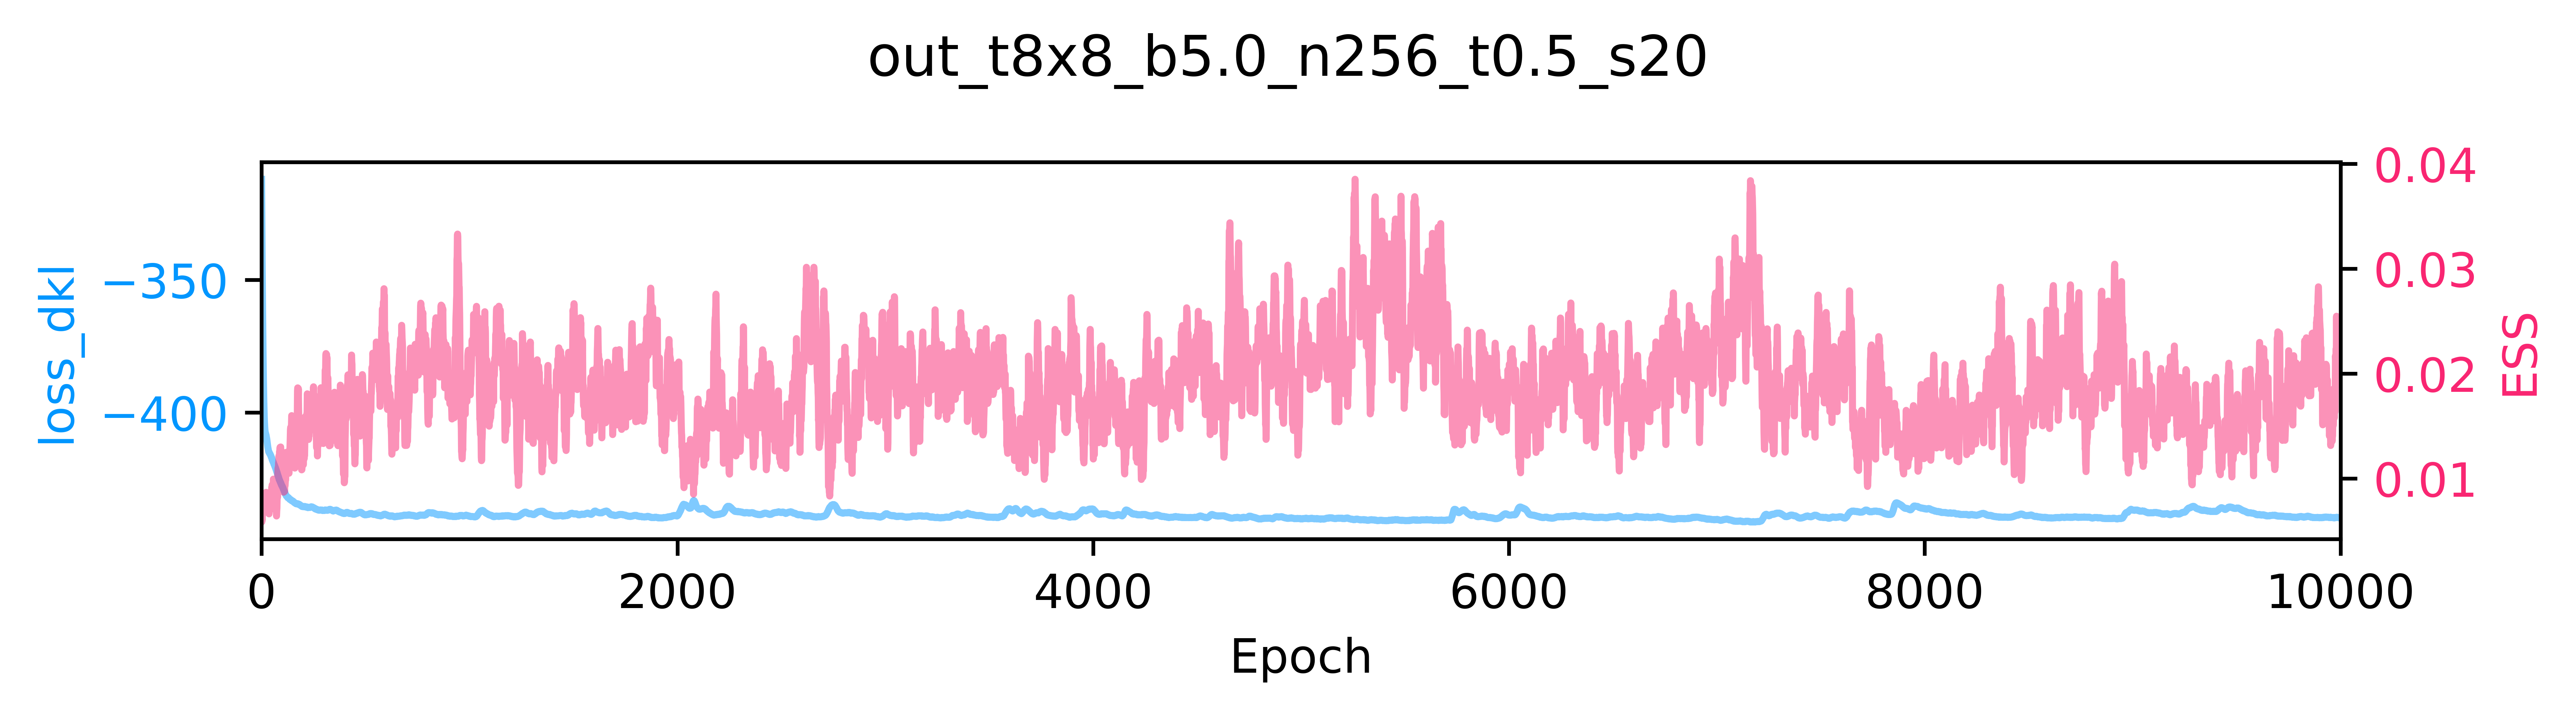

In [6]:
train_outputs = train(param,
                      train_config,
                      #model=model_init,
                      pre_model=None,
                      logger=logger,
                      figsize=(7.5, 2))
 
pre_flow_plots = train_outputs['plots']
pre_flow_history = train_outputs['history']
flow_act = train_outputs['action']

pre_flow_model = train_outputs['model']
pre_flow_optimizer = train_outputs['optimizer_kdl']

step = train_config.n_era * train_config.n_epoch
outfile = os.path.join(MODEL_DIR, 'pre_flow_model', TSTAMP, 'pre_flow_model.tar')

io.save_checkpoint(
    epoch=step,
    outfile=outfile,
    model=train_outputs['model']['layers'],
    optimizer=pre_flow_optimizer,
    history=train_outputs['history'],
    overwrite=True,
)

plots = train_outputs['plots']
outdir = os.path.join(PLOTS_DIR, 'training', 'pre_flow_model', TSTAMP)

save_live_plots(plots, outdir)

[16:56:09]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/dt_165609.pdf

[16:56:09]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/dt_165609.pdf

[16:56:09]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/loss_165609.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/loss_165609.pdf

[16:56:09]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/q_165609.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/q_165609.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/dq_165610.pdf

[16:56:10]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/dq_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/ess_165610.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/ess_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/action_165610.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/action_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/loss_dkl_165610.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/loss_dkl_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/logp_165610.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/logp_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/logq_165610.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1509/logq_165610.pdf

[16:56:10]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/metrics/training/pre_flow_model/2021-05-25-1509/train_metrics_2021-05
            -25-165610.z

[16:56:10]  Saving train_metrics to /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0
            _n256_t0.5_s20/metrics/training/pre_flow_model/2021-05-25-1509/train_metrics_2021
            -05-25-165610.z.

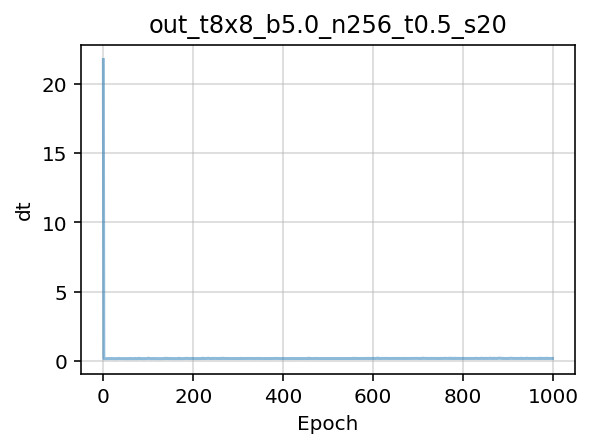

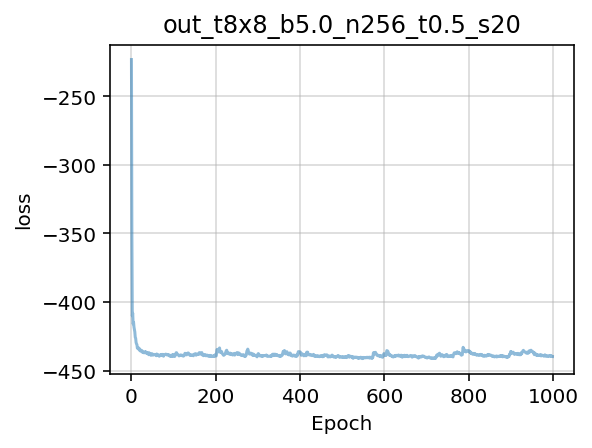

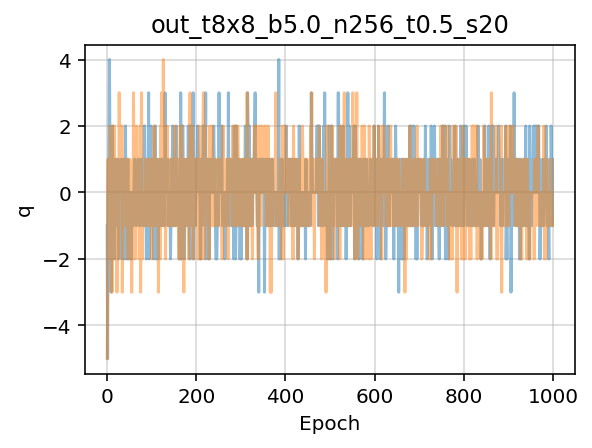

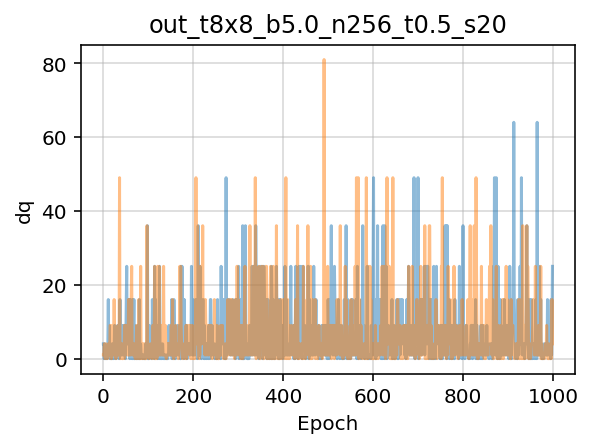

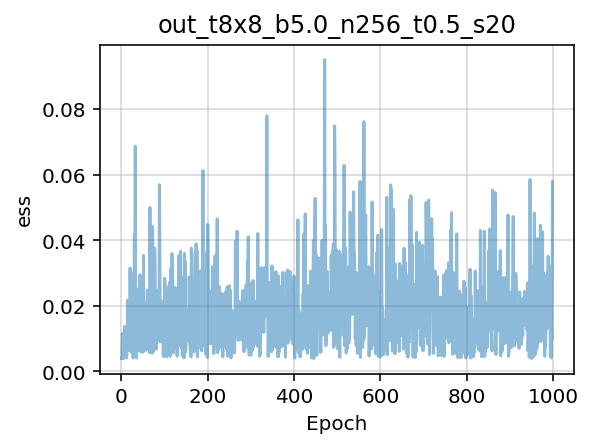

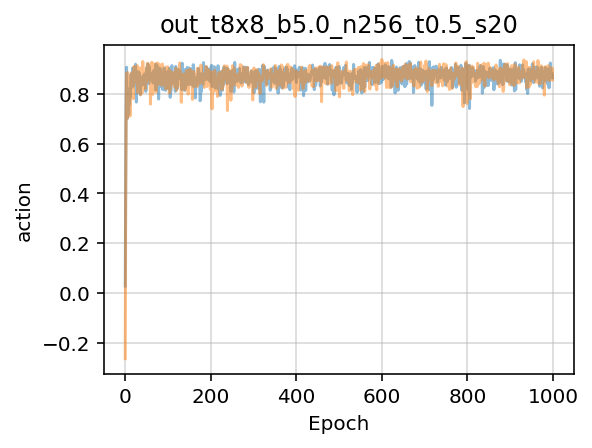

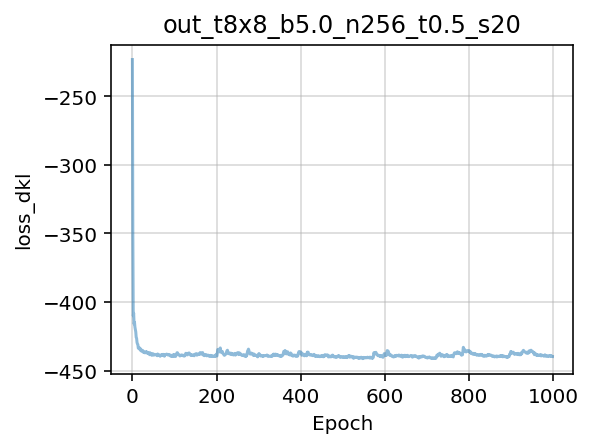

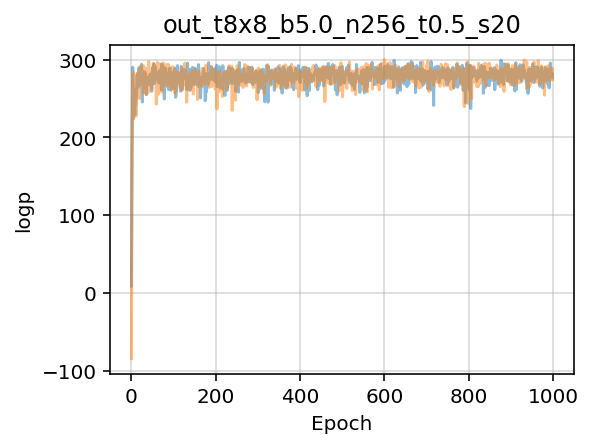

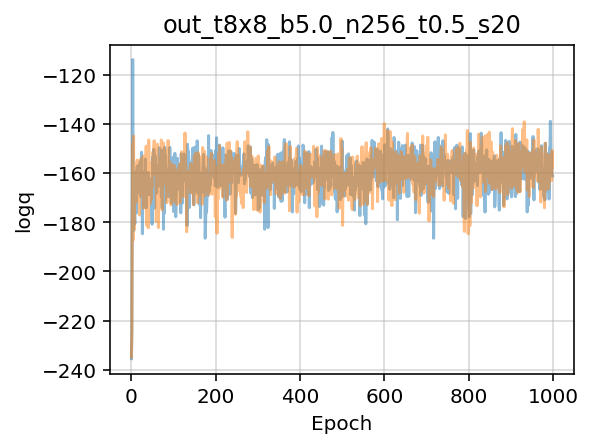

In [23]:
from fthmc.utils.plot_helpers import plot_history

outdir = os.path.join(PLOTS_DIR, 'training', 'pre_flow_model', TSTAMP)
io.check_else_make_dir(outdir)

plot_history(history=train_outputs['history'],
             param=param, skip=['epoch'],
             num_chains=2, therm_frac=0.0, thin=10,
             xlabel='Epoch', outdir=outdir, alpha=0.5)

outdir = os.path.join(METRICS_DIR, 'training', 'pre_flow_model', TSTAMP)
outfile = os.path.join(outdir, 'train_metrics.z')
io.save_history(train_outputs['history'], outfile, name='train_metrics')

## Run inference on trained model and plot history

[16:56:58]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n25
            6_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651

[16:56:58]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/ess.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/q.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/dqsq.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/dkl.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/logq.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/logp.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n256_t0.5_s20/plots/inference/pre_flow_model/2021-05-25-165651/accepted.pdf

[16:56:59]  Existing file found!                                                             
            Renaming outfile to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_b5.0_n2
            56_t0.5_s20/metrics/training/pre_flow_model/2021-05-25-1509/train_metrics_2021-05
            -25-165659.z

[16:56:59]  Saving inference_metrics to /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t8x8_
            b5.0_n256_t0.5_s20/metrics/training/pre_flow_model/2021-05-25-1509/train_metrics_
            2021-05-25-165659.z.

[16:56:59]  Accept rate: 0.0014

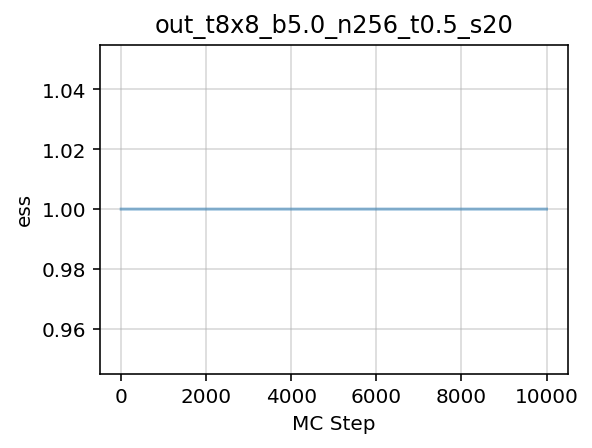

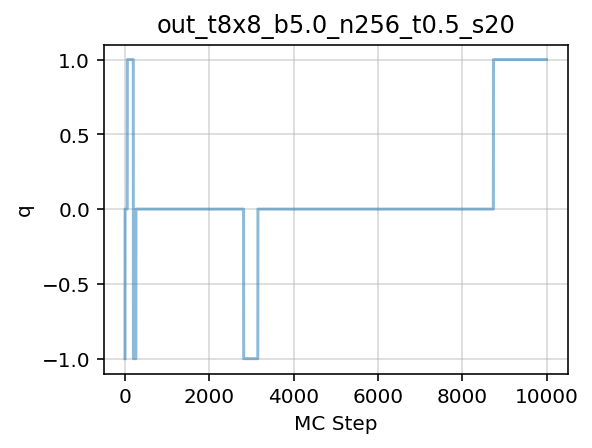

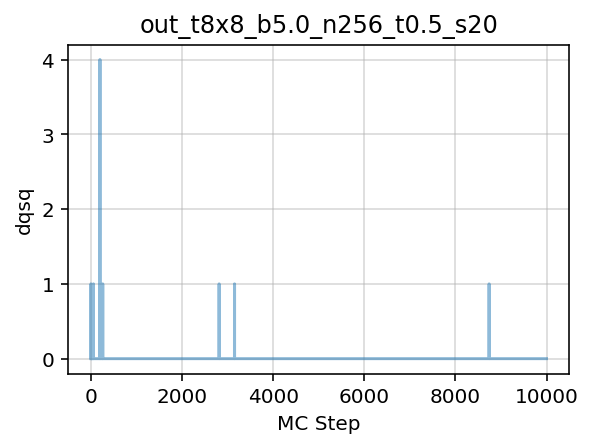

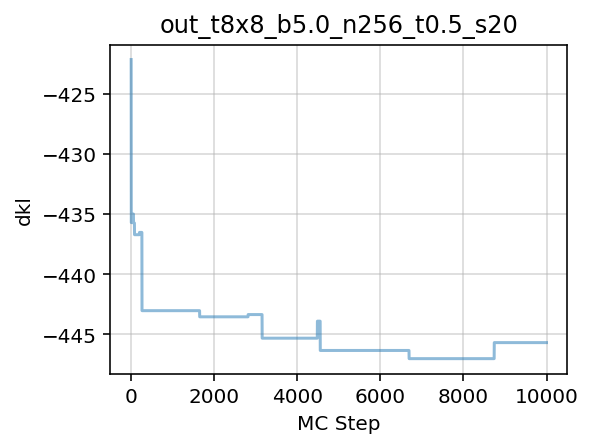

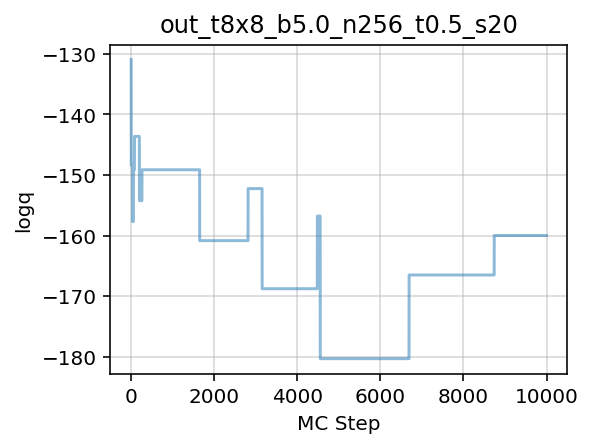

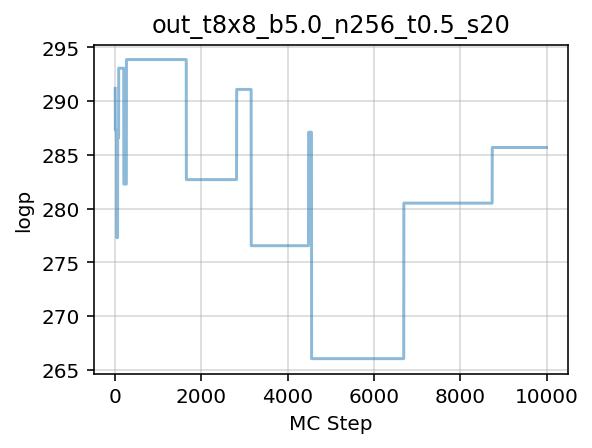

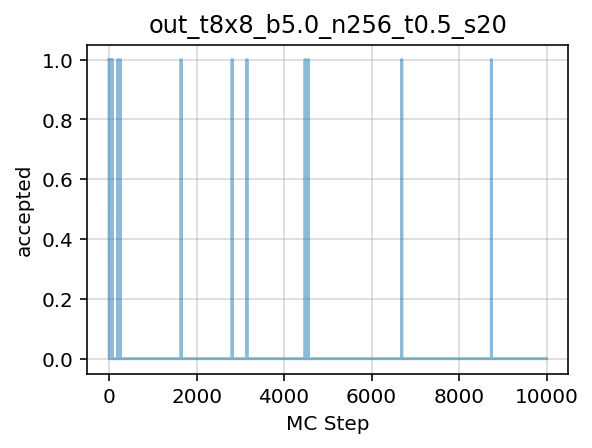

In [24]:
from fthmc.utils.samplers import make_mcmc_ensemble
import fthmc.utils.qed_helpers as qed

tstamp = io.get_timestamp('%Y-%m-%d-%H%M%S')

history = make_mcmc_ensemble(model=train_outputs['model'],
                             action_fn=train_outputs['action'],
                             batch_size=train_config.batch_size,
                             num_samples=10000)

outdir = os.path.join(PLOTS_DIR, 'inference', 'pre_flow_model', TSTAMP)
if os.path.isdir(outdir):
    pdir = os.path.join(PLOTS_DIR, 'inference', 'pre_flow_model', tstamp)
    mdir = os.path.join(METRICS_DIR, 'inference', 'pre_flow_model', TSTAMP)
    
io.check_else_make_dir(pdir)
io.check_else_make_dir(mdir)

plot_history(history=history,
             param=param, skip=['epoch', 'x'],
             num_chains=2, therm_frac=0.0,#, thin=10,
             xlabel='MC Step', outdir=pdir, alpha=0.5)

mfile = os.path.join(mdir, 'inference_metrics.z')

io.save_history(history, outfile, name='inference_metrics')

logger.log(f'Accept rate: {np.mean(history["accepted"])}')

In [25]:
np.mean(history['accepted'])

0.0014

In [26]:
from fthmc.utils.samplers import generate_ensemble

outputs = generate_ensemble(pre_flow_model, flow_act, logger=logger)
u1_ens = outputs['ensemble']

pre_flow = pre_flow_model['layers']

[17:12:00]  accept_rate=0.0107421875

            top_susceptibility=0.41352 +/- 0.05829

In [27]:
train_force = False
flow_model = None

if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
u1_ens = generate_ensemble(flow_model, flow_act, logger=logger)
flow = flow_model['layers']
flow.eval()

[17:12:06]  accept_rate=0.0078125

            top_susceptibility=0.06979 +/- 0.03999

ModuleList(
  (0): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (1): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLayer(
      (net): Sequential(
        (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (1): SiLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
        (3): SiLU()
        (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      )
    )
  )
  (2): GaugeEquivCouplingLayer(
    (plaq_coupling): NCPPlaqCouplingLaye

## Extract layers from `pre_flow_model` and transfer learning to larger lattice

In [28]:
logger.log(repr(param))

[17:12:17]  Param:                                                                                                                                                                                                                                              
            ----------------                                                                                                                                                                                                                                    
            beta=5.0                                                                                                                                                                                                                                            
            L=8                                                                                                                                                                                                                                                 
            tau=0.5                                                                                                                                                                                                                                             
            nstep=20                                                                                                                                                                                                                                            
            ntraj=256                                                                                                                                                                                                                                           
            nrun=5                                                                                                                                                                                                                                              
            nprint=50                                                                                                                                                                                                                                           
            seed=1331                                                                                                                                                                                                                                           
            randinit=True                                                                                                                                                                                                                                       
            nth=2                                                                                                                                                                                                                                               
            nth_interop=2                                                                                                                                                                                                                                       
            lat=[8, 8]                                                                                                                                                                                                                                          
            nd=2                                                                                                                                                                                                                                                
            shape=[2, 8, 8]                                                                                                                      

In [31]:
logger.log(train_config)

[17:13:09]  TrainConfig(n_era=10, n_epoch=1000, n_layers=32, n_s_nets=2, hidden_sizes=[8, 8], kernel_size=3, base_lr=0.001, batch_size=256, print_freq=100, plot_freq=100, with_force=False)

In [32]:
from math import pi as PI
from fthmc.utils.distributions import MultivariateUniform
from fthmc.utils.layers import make_net_from_layers, get_nets

param12 = {
    'L': 12,
    'tau': 0.5,
    'nrun': 5,
    'beta': 5.,
    'nstep': 20,
    'ntraj': 256,
    'nprint': 50,
    'seed': 1331,
    'randinit': True,
}

param12 = Param(**param12)
logger.log(repr(param12))

flow12 = make_net_from_layers(lattice_shape=tuple(param12.lat),
                              nets=get_nets(pre_flow_model['layers']))

train_config12 = TrainConfig(**{
    'n_era': 10,
    'n_epoch': 1000,
    'n_layers': 32,
    'n_s_nets': 2,
    'hidden_sizes': [12, 12],
    'kernel_size': 3,
    'batch_size': 256,
    'print_freq': 100,
    'plot_freq': 100,
})

prior12 = MultivariateUniform(torch.zeros((2, *param12.lat)),
                              2. * PI * torch.ones(tuple(param12.lat)))

model12 = {'layers': flow12, 'prior': prior12}

[17:14:06]  Param:                                                                                                                                                                                                                                              
            ----------------                                                                                                                                                                                                                                    
            beta=5.0                                                                                                                                                                                                                                            
            L=12                                                                                                                                                                                                                                                
            tau=0.5                                                                                                                                                                                                                                             
            nstep=20                                                                                                                                                                                                                                            
            ntraj=256                                                                                                                                                                                                                                           
            nrun=5                                                                                                                                                                                                                                              
            nprint=50                                                                                                                                                                                                                                           
            seed=1331                                                                                                                                                                                                                                           
            randinit=True                                                                                                                                                                                                                                       
            nth=2                                                                                                                                                                                                                                               
            nth_interop=2                                                                                                                                                                                                                                       
            lat=[12, 12]                                                                                                                                                                                                                                        
            nd=2                                                                                                                                                                                                                                                
            shape=[2, 12, 12]                                                                                                                    

In [33]:
DAYSTR12 = io.get_timestamp('%Y-%m-%d')
NOW12 = io.get_timestamp('%Y-%m-%d-%H%M%S')
TSTAMP12 = io.get_timestamp('%Y-%m-%d-%H%M')

PARAM_DIR12 = os.path.join(LOGS_DIR,
                           param12.uniquestr())
METRICS_DIR12 = os.path.join(PARAM_DIR12, 'metrics')
MODEL_DIR12 = os.path.join(PARAM_DIR12, 'models')
PLOTS_DIR12 = os.path.join(PARAM_DIR12, 'plots')
#OUTDIR = os.path.join(METRICS_DIR)

io.check_else_make_dir(PARAM_DIR12)
io.check_else_make_dir(MODEL_DIR12)
io.check_else_make_dir(METRICS_DIR12)
io.check_else_make_dir(PLOTS_DIR12)

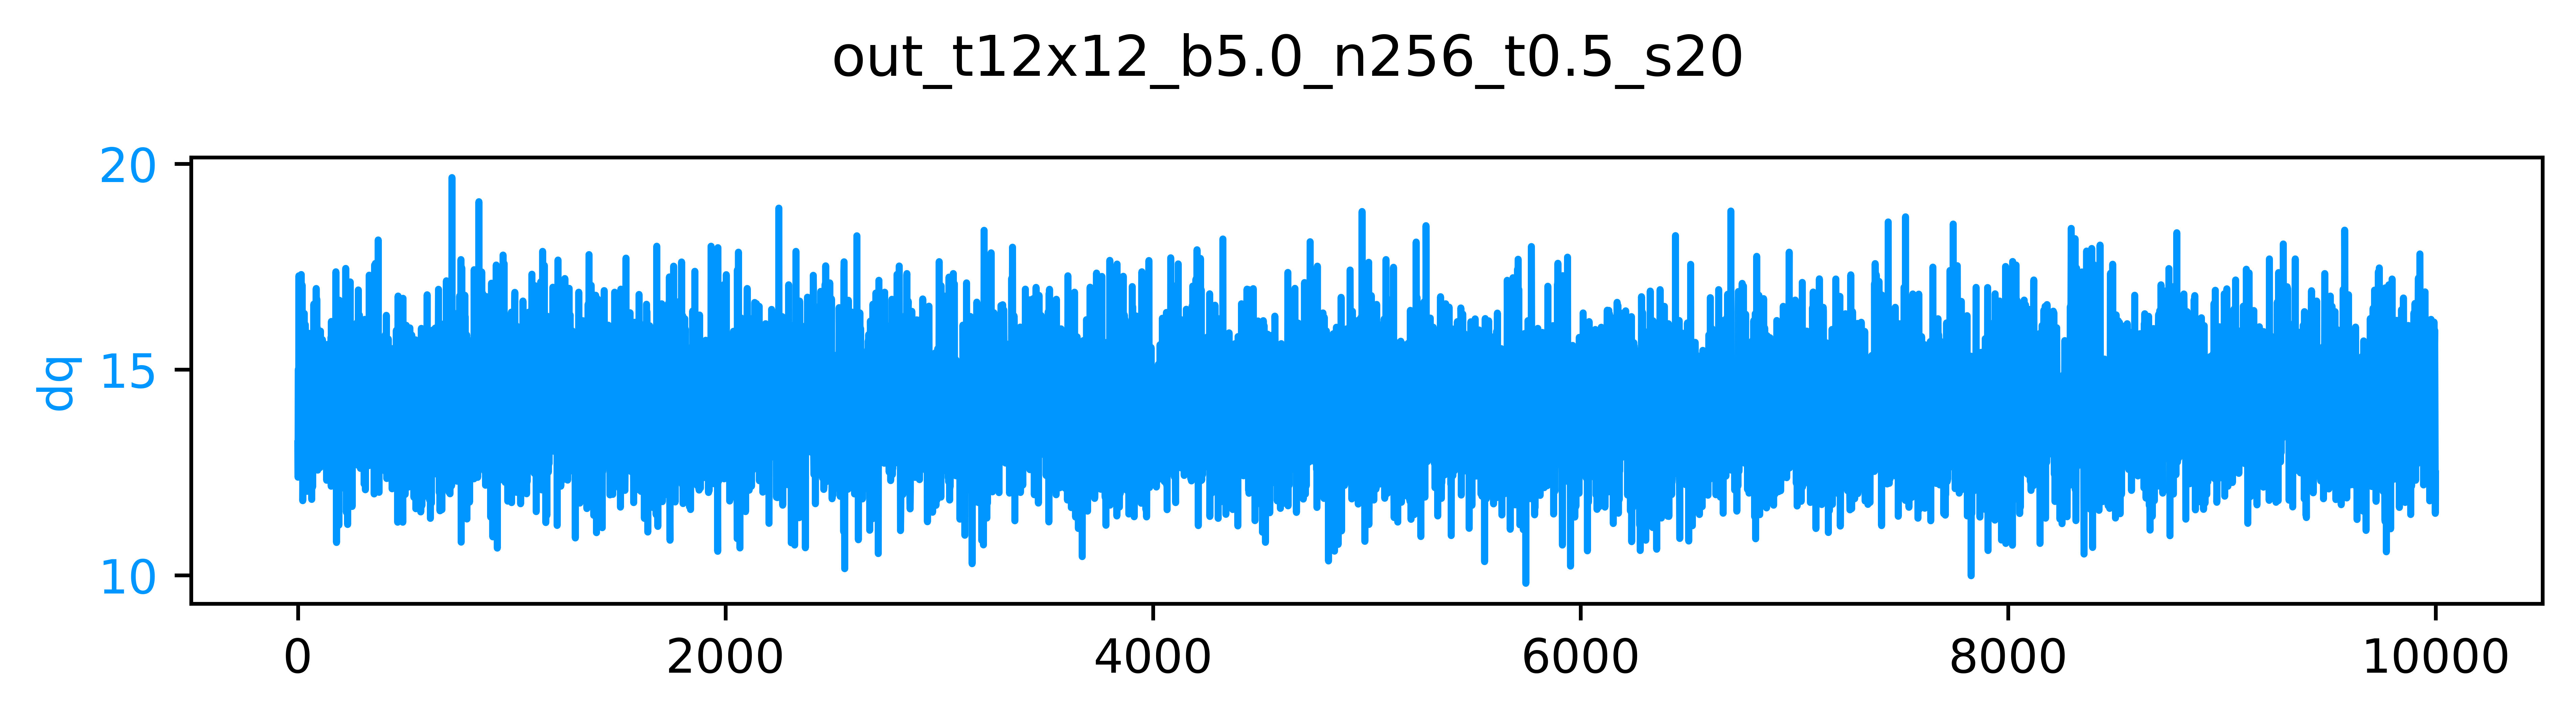

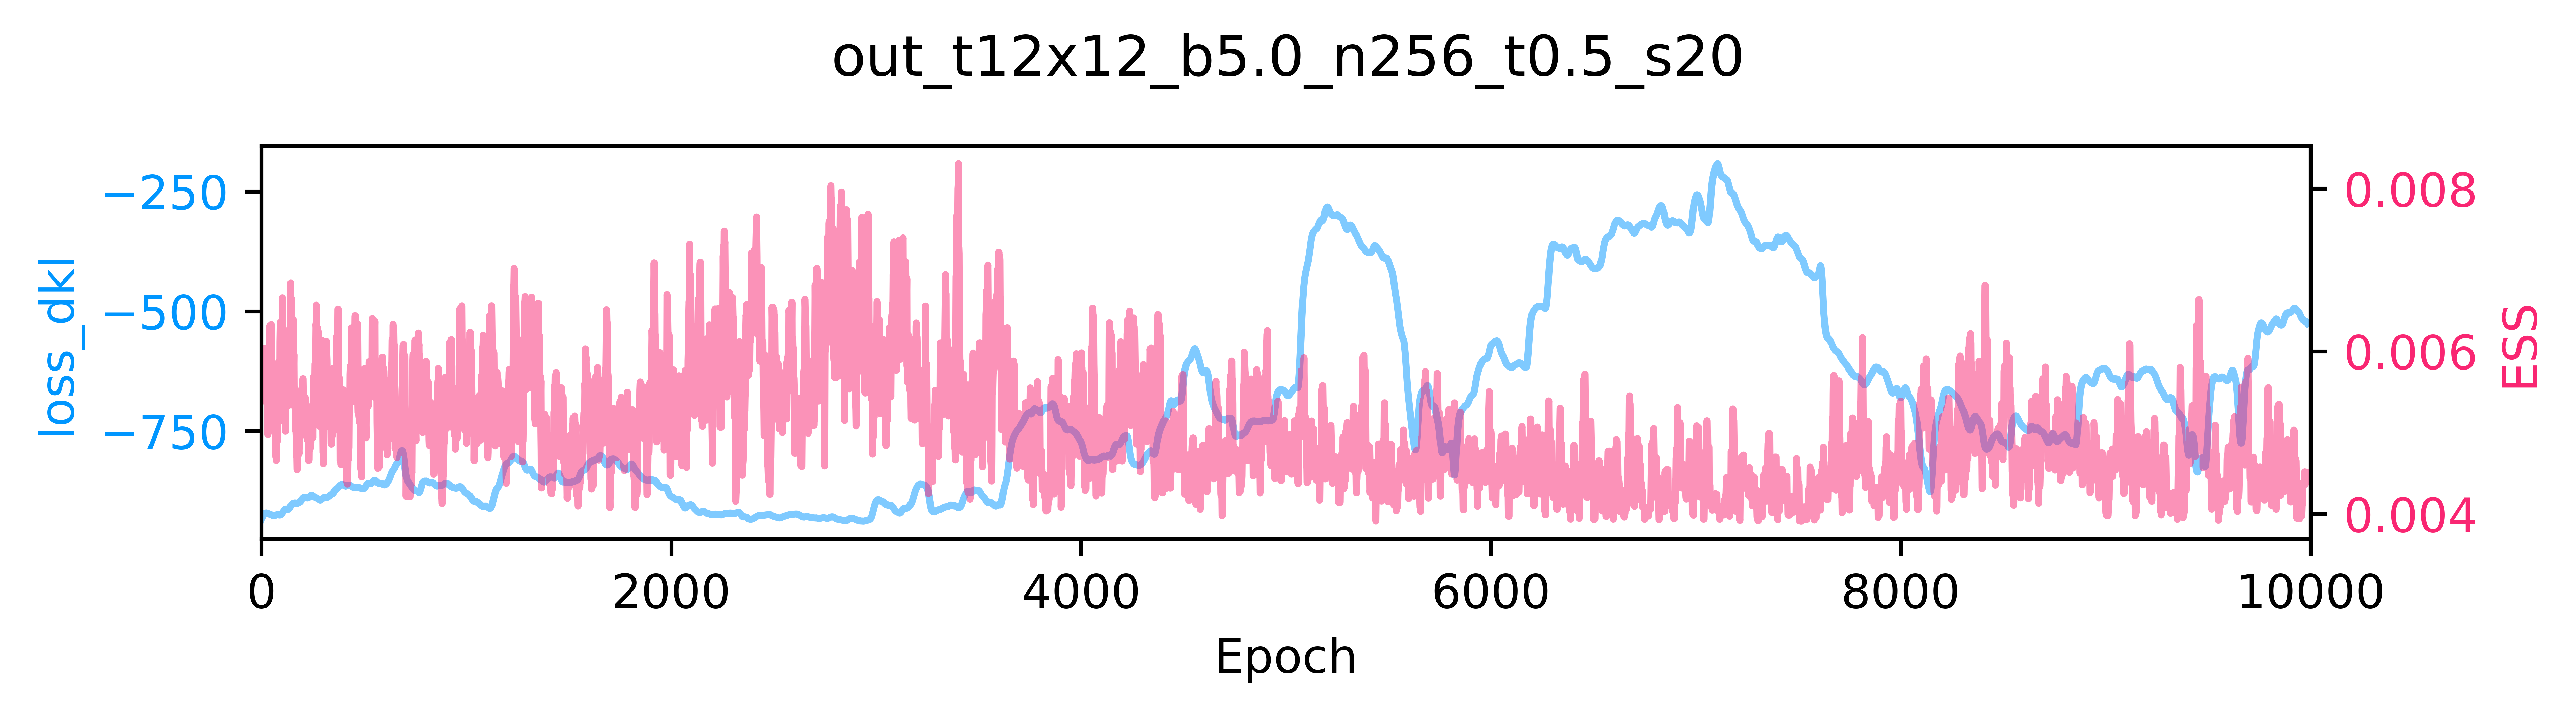

[17:19:25]  ---------------------------------------                                                                                                                                                                                                             
            ERA=0, last took: 0 min 0 s                                                                                                                                                                                                                         
            ---------------------------------------

[17:19:43]  epoch=97.000 step=0.000 dt=0.175 loss=-925.248 dq=14.0906 ess=0.00506614 plaq=0.873208 loss_dkl=-925.248 logp=628.709 logq=-296.539

[17:20:03]  epoch=197.000 step=0.000 dt=0.175 loss=-897.769 dq=14.4273 ess=0.00436365 plaq=0.86955 loss_dkl=-897.769 logp=626.076 logq=-271.693

[17:20:22]  epoch=297.000 step=0.000 dt=0.175 loss=-893.85 dq=14.3742 ess=0.0074217 plaq=0.871898 loss_dkl=-893.85 logp=627.766 logq=-266.084

[17:20:42]  epoch=397.000 step=0.000 dt=0.176 loss=-861.19 dq=14.3281 ess=0.0042834 plaq=0.870438 loss_dkl=-861.19 logp=626.716 logq=-234.474

[17:21:01]  epoch=497.000 step=0.000 dt=0.177 loss=-869.484 dq=13.3664 ess=0.00475632 plaq=0.874705 loss_dkl=-869.484 logp=629.788 logq=-239.696

[17:21:21]  epoch=597.000 step=0.000 dt=0.175 loss=-860.624 dq=13.9125 ess=0.00498772 plaq=0.876487 loss_dkl=-860.624 logp=631.071 logq=-229.553

[17:21:40]  epoch=697.000 step=0.000 dt=0.175 loss=-790.349 dq=14.8523 ess=0.00599379 plaq=0.872408 loss_dkl=-790.349 logp=628.134 logq=-162.215

[17:22:00]  epoch=797.000 step=0.000 dt=0.175 loss=-855.505 dq=14.3484 ess=0.00462887 plaq=0.875759 loss_dkl=-855.505 logp=630.546 logq=-224.959

[17:22:19]  epoch=897.000 step=0.000 dt=0.176 loss=-860.945 dq=14.4875 ess=0.00483231 plaq=0.871899 loss_dkl=-860.945 logp=627.767 logq=-233.178

[17:22:39]  epoch=997.000 step=0.000 dt=0.177 loss=-876.245 dq=15.0094 ess=0.00472491 plaq=0.871876 loss_dkl=-876.245 logp=627.751 logq=-248.494

[17:22:40]  ---------------------------------------                                                                                                                                                                                                             
            ERA=1, last took: 3 min 15.13 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:22:58]  epoch=97.000 step=97.000 dt=0.176 loss=-907.193 dq=14.6023 ess=0.0046834 plaq=0.875478 loss_dkl=-907.193 logp=630.344 logq=-276.849

[17:23:18]  epoch=197.000 step=197.000 dt=0.175 loss=-820.636 dq=14.2117 ess=0.00463298 plaq=0.872482 loss_dkl=-820.636 logp=628.187 logq=-192.448

[17:23:37]  epoch=297.000 step=297.000 dt=0.177 loss=-832.116 dq=13.9125 ess=0.00616718 plaq=0.877751 loss_dkl=-832.116 logp=631.981 logq=-200.135

[17:23:58]  epoch=397.000 step=397.000 dt=0.176 loss=-852.371 dq=14.1523 ess=0.00521405 plaq=0.87827 loss_dkl=-852.371 logp=632.354 logq=-220.017

[17:24:17]  epoch=497.000 step=497.000 dt=0.176 loss=-858.09 dq=14.1555 ess=0.00404078 plaq=0.874397 loss_dkl=-858.09 logp=629.565 logq=-228.525

[17:24:37]  epoch=597.000 step=597.000 dt=0.176 loss=-821.939 dq=14.6914 ess=0.00609858 plaq=0.875071 loss_dkl=-821.939 logp=630.051 logq=-191.888

[17:24:57]  epoch=697.000 step=697.000 dt=0.176 loss=-821.958 dq=13.7297 ess=0.00794553 plaq=0.876269 loss_dkl=-821.958 logp=630.914 logq=-191.045

[17:25:16]  epoch=797.000 step=797.000 dt=0.176 loss=-830.098 dq=14.3297 ess=0.00651059 plaq=0.878815 loss_dkl=-830.098 logp=632.747 logq=-197.351

[17:25:36]  epoch=897.000 step=897.000 dt=0.176 loss=-852.897 dq=13.6297 ess=0.00467581 plaq=0.878482 loss_dkl=-852.897 logp=632.507 logq=-220.391

[17:25:56]  epoch=997.000 step=997.000 dt=0.176 loss=-882.178 dq=15.1906 ess=0.00398825 plaq=0.876498 loss_dkl=-882.178 logp=631.078 logq=-251.1

[17:25:57]  ---------------------------------------                                                                                                                                                                                                             
            ERA=2, last took: 3 min 16.95 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:26:15]  epoch=97.000 step=194.000 dt=0.175 loss=-904.791 dq=13.2586 ess=0.00864525 plaq=0.874119 loss_dkl=-904.791 logp=629.365 logq=-275.425

[17:26:35]  epoch=197.000 step=394.000 dt=0.176 loss=-923.802 dq=14.0969 ess=0.00725539 plaq=0.875676 loss_dkl=-923.802 logp=630.487 logq=-293.315

[17:26:55]  epoch=297.000 step=594.000 dt=0.176 loss=-920.61 dq=14.1023 ess=0.00722522 plaq=0.87531 loss_dkl=-920.61 logp=630.223 logq=-290.387

[17:27:14]  epoch=397.000 step=794.000 dt=0.176 loss=-934.259 dq=14.5086 ess=0.00708366 plaq=0.876277 loss_dkl=-934.259 logp=630.919 logq=-303.34

[17:27:34]  epoch=497.000 step=994.000 dt=0.176 loss=-926.924 dq=14.2867 ess=0.0055142 plaq=0.876615 loss_dkl=-926.924 logp=631.163 logq=-295.762

[17:27:54]  epoch=597.000 step=1194.000 dt=0.176 loss=-924.105 dq=14.593 ess=0.00685703 plaq=0.876896 loss_dkl=-924.105 logp=631.365 logq=-292.741

[17:28:13]  epoch=697.000 step=1394.000 dt=0.176 loss=-931.28 dq=13.657 ess=0.00452385 plaq=0.877303 loss_dkl=-931.28 logp=631.658 logq=-299.622

[17:28:33]  epoch=797.000 step=1594.000 dt=0.176 loss=-929.129 dq=15.0742 ess=0.00600996 plaq=0.877048 loss_dkl=-929.129 logp=631.475 logq=-297.654

[17:28:53]  epoch=897.000 step=1794.000 dt=0.176 loss=-932.621 dq=14.6469 ess=0.00622322 plaq=0.877247 loss_dkl=-932.621 logp=631.618 logq=-301.004

[17:29:13]  epoch=997.000 step=1994.000 dt=0.176 loss=-907.327 dq=14.0289 ess=0.00581858 plaq=0.881328 loss_dkl=-907.327 logp=634.556 logq=-272.771

[17:29:14]  ---------------------------------------                                                                                                                                                                                                             
            ERA=3, last took: 3 min 16.98 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:29:32]  epoch=97.000 step=291.000 dt=0.176 loss=-915.464 dq=13.3742 ess=0.00715377 plaq=0.878932 loss_dkl=-915.464 logp=632.831 logq=-282.633

[17:29:52]  epoch=197.000 step=591.000 dt=0.176 loss=-875.394 dq=13.6578 ess=0.00484447 plaq=0.877907 loss_dkl=-875.394 logp=632.093 logq=-243.301

[17:30:12]  epoch=297.000 step=891.000 dt=0.176 loss=-918.383 dq=14.2266 ess=0.00541956 plaq=0.869482 loss_dkl=-918.383 logp=626.027 logq=-292.356

[17:30:32]  epoch=397.000 step=1191.000 dt=0.176 loss=-907.31 dq=13.8656 ess=0.00419782 plaq=0.876026 loss_dkl=-907.31 logp=630.738 logq=-276.572

[17:30:51]  epoch=497.000 step=1491.000 dt=0.176 loss=-875.205 dq=14.8352 ess=0.00508985 plaq=0.878322 loss_dkl=-875.205 logp=632.392 logq=-242.813

[17:31:11]  epoch=597.000 step=1791.000 dt=0.176 loss=-905.2 dq=14.0211 ess=0.0062389 plaq=0.878494 loss_dkl=-905.2 logp=632.515 logq=-272.684

[17:31:31]  epoch=697.000 step=2091.000 dt=0.176 loss=-748.709 dq=14.2797 ess=0.00519615 plaq=0.876672 loss_dkl=-748.709 logp=631.204 logq=-117.505

[17:31:51]  epoch=797.000 step=2391.000 dt=0.176 loss=-707.191 dq=14.4219 ess=0.00588877 plaq=0.879735 loss_dkl=-707.191 logp=633.409 logq=-73.7817

[17:32:11]  epoch=897.000 step=2691.000 dt=0.176 loss=-729.435 dq=14.1703 ess=0.00604097 plaq=0.879533 loss_dkl=-729.435 logp=633.264 logq=-96.1711

[17:32:30]  epoch=997.000 step=2991.000 dt=0.176 loss=-765.58 dq=13.3672 ess=0.00403201 plaq=0.877055 loss_dkl=-765.58 logp=631.48 logq=-134.1

[17:32:32]  ---------------------------------------                                                                                                                                                                                                             
            ERA=4, last took: 3 min 17.98 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:32:50]  epoch=97.000 step=388.000 dt=0.176 loss=-806.795 dq=14.3453 ess=0.00495828 plaq=0.875311 loss_dkl=-806.795 logp=630.224 logq=-176.571

[17:33:10]  epoch=197.000 step=788.000 dt=0.176 loss=-777.806 dq=14.3609 ess=0.00602271 plaq=0.878316 loss_dkl=-777.806 logp=632.387 logq=-145.419

[17:33:30]  epoch=297.000 step=1188.000 dt=0.176 loss=-819.941 dq=14.418 ess=0.00425509 plaq=0.877707 loss_dkl=-819.941 logp=631.949 logq=-187.992

[17:33:50]  epoch=397.000 step=1588.000 dt=0.177 loss=-741.062 dq=13.8016 ess=0.00463249 plaq=0.879128 loss_dkl=-741.062 logp=632.972 logq=-108.091

[17:34:10]  epoch=497.000 step=1988.000 dt=0.176 loss=-684.91 dq=14.2023 ess=0.00704247 plaq=0.87884 loss_dkl=-684.91 logp=632.765 logq=-52.1452

[17:34:30]  epoch=597.000 step=2388.000 dt=0.176 loss=-628.527 dq=13.4711 ess=0.00570103 plaq=0.876461 loss_dkl=-628.527 logp=631.052 logq=2.52429

[17:34:50]  epoch=697.000 step=2788.000 dt=0.176 loss=-724.534 dq=13.3906 ess=0.00391649 plaq=0.879234 loss_dkl=-724.534 logp=633.048 logq=-91.4855

[17:35:09]  epoch=797.000 step=3188.000 dt=0.176 loss=-754.611 dq=14.8828 ess=0.00487336 plaq=0.879198 loss_dkl=-754.611 logp=633.023 logq=-121.588

[17:35:29]  epoch=897.000 step=3588.000 dt=0.177 loss=-727.134 dq=13.9664 ess=0.00536523 plaq=0.875278 loss_dkl=-727.134 logp=630.2 logq=-96.9341

[17:35:49]  epoch=997.000 step=3988.000 dt=0.177 loss=-665.551 dq=13.3781 ess=0.00402759 plaq=0.878097 loss_dkl=-665.551 logp=632.23 logq=-33.3206

[17:35:51]  ---------------------------------------                                                                                                                                                                                                             
            ERA=5, last took: 3 min 18.92 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:36:09]  epoch=97.000 step=485.000 dt=0.176 loss=-431.335 dq=14.0281 ess=0.0059687 plaq=0.876759 loss_dkl=-431.335 logp=631.266 logq=199.932

[17:36:29]  epoch=197.000 step=985.000 dt=0.176 loss=-291.153 dq=13.6141 ess=0.00426148 plaq=0.878903 loss_dkl=-291.153 logp=632.81 logq=341.657

[17:36:50]  epoch=297.000 step=1485.000 dt=0.183 loss=-323.676 dq=15.0031 ess=0.00445531 plaq=0.877687 loss_dkl=-323.676 logp=631.934 logq=308.258

[17:37:11]  epoch=397.000 step=1985.000 dt=0.183 loss=-375.313 dq=13.8695 ess=0.00452432 plaq=0.878578 loss_dkl=-375.313 logp=632.576 logq=257.263

[17:37:31]  epoch=497.000 step=2485.000 dt=0.180 loss=-389.995 dq=14.0383 ess=0.00428089 plaq=0.880129 loss_dkl=-389.995 logp=633.693 logq=243.698

[17:37:52]  epoch=597.000 step=2985.000 dt=0.183 loss=-644.769 dq=14.1375 ess=0.00458627 plaq=0.880118 loss_dkl=-644.769 logp=633.685 logq=-11.0844

[17:38:12]  epoch=697.000 step=3485.000 dt=0.180 loss=-650.379 dq=14.5258 ess=0.00392672 plaq=0.882429 loss_dkl=-650.379 logp=635.349 logq=-15.0303

[17:38:33]  epoch=797.000 step=3985.000 dt=0.182 loss=-788.633 dq=13.8188 ess=0.00507699 plaq=0.880018 loss_dkl=-788.633 logp=633.613 logq=-155.02

[17:38:53]  epoch=897.000 step=4485.000 dt=0.179 loss=-689.443 dq=14.2531 ess=0.00537323 plaq=0.876 loss_dkl=-689.443 logp=630.72 logq=-58.7223

[17:39:14]  epoch=997.000 step=4985.000 dt=0.179 loss=-586.53 dq=14.0047 ess=0.00397507 plaq=0.878613 loss_dkl=-586.53 logp=632.602 logq=46.0716

[17:39:16]  ---------------------------------------                                                                                                                                                                                                             
            ERA=6, last took: 3 min 24.22 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:39:34]  epoch=97.000 step=582.000 dt=0.182 loss=-615.163 dq=14.6672 ess=0.00390644 plaq=0.876976 loss_dkl=-615.163 logp=631.422 logq=16.259

[17:39:54]  epoch=197.000 step=1182.000 dt=0.179 loss=-530.809 dq=15.0094 ess=0.00499085 plaq=0.884975 loss_dkl=-530.809 logp=637.182 logq=106.373

[17:40:15]  epoch=297.000 step=1782.000 dt=0.185 loss=-380.658 dq=14.1094 ess=0.00446583 plaq=0.880315 loss_dkl=-380.658 logp=633.827 logq=253.169

[17:40:35]  epoch=397.000 step=2382.000 dt=0.180 loss=-368.431 dq=13.5086 ess=0.00397914 plaq=0.878613 loss_dkl=-368.431 logp=632.601 logq=264.171

[17:40:56]  epoch=497.000 step=2982.000 dt=0.186 loss=-407.239 dq=13.7422 ess=0.00391291 plaq=0.8806 loss_dkl=-407.239 logp=634.032 logq=226.792

[17:41:16]  epoch=597.000 step=3582.000 dt=0.183 loss=-337.825 dq=13.5219 ess=0.00454826 plaq=0.879952 loss_dkl=-337.825 logp=633.565 logq=295.74

[17:41:36]  epoch=697.000 step=4182.000 dt=0.179 loss=-332.51 dq=14.5742 ess=0.00435985 plaq=0.880504 loss_dkl=-332.51 logp=633.963 logq=301.453

[17:41:57]  epoch=797.000 step=4782.000 dt=0.179 loss=-323.053 dq=13.4805 ess=0.00620165 plaq=0.878376 loss_dkl=-323.053 logp=632.431 logq=309.378

[17:42:17]  epoch=897.000 step=5382.000 dt=0.179 loss=-311.532 dq=13.1438 ess=0.00391768 plaq=0.878111 loss_dkl=-311.532 logp=632.24 logq=320.707

[17:42:38]  epoch=997.000 step=5982.000 dt=0.180 loss=-275.356 dq=14.0391 ess=0.0039063 plaq=0.875591 loss_dkl=-275.356 logp=630.425 logq=355.069

[17:42:40]  ---------------------------------------                                                                                                                                                                                                             
            ERA=7, last took: 3 min 24.44 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:42:58]  epoch=97.000 step=679.000 dt=0.181 loss=-208.768 dq=14.1008 ess=0.00425262 plaq=0.877191 loss_dkl=-208.768 logp=631.577 logq=422.81

[17:43:19]  epoch=197.000 step=1379.000 dt=0.181 loss=-261.46 dq=14.4875 ess=0.00395466 plaq=0.881187 loss_dkl=-261.46 logp=634.455 logq=372.995

[17:43:39]  epoch=297.000 step=2079.000 dt=0.178 loss=-352.327 dq=13.8813 ess=0.00490464 plaq=0.878686 loss_dkl=-352.327 logp=632.654 logq=280.327

[17:44:00]  epoch=397.000 step=2779.000 dt=0.178 loss=-356.07 dq=15.2742 ess=0.00510809 plaq=0.874391 loss_dkl=-356.07 logp=629.562 logq=273.491

[17:44:20]  epoch=497.000 step=3479.000 dt=0.176 loss=-367.998 dq=13.575 ess=0.00444085 plaq=0.880165 loss_dkl=-367.998 logp=633.719 logq=265.72

[17:44:40]  epoch=597.000 step=4179.000 dt=0.176 loss=-423.795 dq=13.8547 ess=0.00396427 plaq=0.879183 loss_dkl=-423.795 logp=633.012 logq=209.217

[17:45:00]  epoch=697.000 step=4879.000 dt=0.176 loss=-584.915 dq=13.6938 ess=0.00523161 plaq=0.87731 loss_dkl=-584.915 logp=631.663 logq=46.7479

[17:45:20]  epoch=797.000 step=5579.000 dt=0.176 loss=-635.654 dq=14.3836 ess=0.00421332 plaq=0.878627 loss_dkl=-635.654 logp=632.611 logq=-3.04264

[17:45:40]  epoch=897.000 step=6279.000 dt=0.175 loss=-619.13 dq=14.368 ess=0.00397177 plaq=0.878414 loss_dkl=-619.13 logp=632.458 logq=13.328

[17:46:00]  epoch=997.000 step=6979.000 dt=0.175 loss=-673.3 dq=14.3023 ess=0.00431005 plaq=0.877713 loss_dkl=-673.3 logp=631.953 logq=-41.3468

[17:46:02]  ---------------------------------------                                                                                                                                                                                                             
            ERA=8, last took: 3 min 22.22 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:46:20]  epoch=97.000 step=776.000 dt=0.180 loss=-772.07 dq=15.4281 ess=0.0041635 plaq=0.877493 loss_dkl=-772.07 logp=631.795 logq=-140.276

[17:46:40]  epoch=197.000 step=1576.000 dt=0.176 loss=-707.942 dq=14.3781 ess=0.00405547 plaq=0.878248 loss_dkl=-707.942 logp=632.338 logq=-75.6039

[17:47:00]  epoch=297.000 step=2376.000 dt=0.175 loss=-691.85 dq=16.3969 ess=0.00711571 plaq=0.875215 loss_dkl=-691.85 logp=630.155 logq=-61.6952

[17:47:20]  epoch=397.000 step=3176.000 dt=0.175 loss=-734.351 dq=14.3258 ess=0.00556899 plaq=0.87392 loss_dkl=-734.351 logp=629.222 logq=-105.129

[17:47:40]  epoch=497.000 step=3976.000 dt=0.175 loss=-770.369 dq=13.5922 ess=0.00513376 plaq=0.876688 loss_dkl=-770.369 logp=631.216 logq=-139.153

[17:48:00]  epoch=597.000 step=4776.000 dt=0.176 loss=-738.145 dq=13.9969 ess=0.00410192 plaq=0.878296 loss_dkl=-738.145 logp=632.373 logq=-105.772

[17:48:20]  epoch=697.000 step=5576.000 dt=0.177 loss=-751.131 dq=14.5789 ess=0.0056173 plaq=0.879501 loss_dkl=-751.131 logp=633.241 logq=-117.891

[17:48:40]  epoch=797.000 step=6376.000 dt=0.175 loss=-760.825 dq=13.8484 ess=0.00523276 plaq=0.879881 loss_dkl=-760.825 logp=633.514 logq=-127.31

[17:49:01]  epoch=897.000 step=7176.000 dt=0.177 loss=-644.663 dq=13.568 ess=0.00392802 plaq=0.877488 loss_dkl=-644.663 logp=631.792 logq=-12.8716

[17:49:22]  epoch=997.000 step=7976.000 dt=0.175 loss=-618.34 dq=13.5219 ess=0.00504547 plaq=0.8771 loss_dkl=-618.34 logp=631.512 logq=13.1728

[17:49:24]  ---------------------------------------                                                                                                                                                                                                             
            ERA=9, last took: 3 min 21.88 s                                                                                                                                                                                                                     
            ---------------------------------------

[17:49:42]  epoch=97.000 step=873.000 dt=0.175 loss=-649.662 dq=14.6492 ess=0.0045582 plaq=0.874306 loss_dkl=-649.662 logp=629.5 logq=-20.1616

[17:50:02]  epoch=197.000 step=1773.000 dt=0.175 loss=-622.726 dq=13.6961 ess=0.00448006 plaq=0.877874 loss_dkl=-622.726 logp=632.069 logq=9.34366

[17:50:22]  epoch=297.000 step=2673.000 dt=0.175 loss=-679.985 dq=14.6477 ess=0.0053897 plaq=0.878258 loss_dkl=-679.985 logp=632.346 logq=-47.6394

[17:50:42]  epoch=397.000 step=3573.000 dt=0.175 loss=-752.232 dq=13.057 ess=0.00431656 plaq=0.880082 loss_dkl=-752.232 logp=633.659 logq=-118.573

[17:51:02]  epoch=497.000 step=4473.000 dt=0.175 loss=-824.513 dq=14.2648 ess=0.00631785 plaq=0.88104 loss_dkl=-824.513 logp=634.349 logq=-190.165

[17:51:22]  epoch=597.000 step=5373.000 dt=0.176 loss=-644.581 dq=13.9539 ess=0.00423223 plaq=0.877109 loss_dkl=-644.581 logp=631.518 logq=-13.0623

[17:51:42]  epoch=697.000 step=6273.000 dt=0.175 loss=-620.778 dq=14.6086 ess=0.00685021 plaq=0.87653 loss_dkl=-620.778 logp=631.101 logq=10.3235

[17:52:03]  epoch=797.000 step=7173.000 dt=0.190 loss=-545.525 dq=14.6016 ess=0.00447211 plaq=0.874172 loss_dkl=-545.525 logp=629.404 logq=83.8792

[17:52:23]  epoch=897.000 step=8073.000 dt=0.180 loss=-503.164 dq=14.9711 ess=0.00417132 plaq=0.878374 loss_dkl=-503.164 logp=632.43 logq=129.266

[17:52:44]  epoch=997.000 step=8973.000 dt=0.186 loss=-529.775 dq=13.5344 ess=0.00421481 plaq=0.876295 loss_dkl=-529.775 logp=630.933 logq=101.158

[17:52:46]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t12x12_b5.0_n
            256_t0.5_s20/models/pre_flow_model/2021-05-25-1714

[17:52:46]  Saving checkpoint to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t12x12_b5.0
            _n256_t0.5_s20/models/pre_flow_model/2021-05-25-1714/pre_flow_model.tar

[17:52:48]  Creating directory: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t12x12_b5.0_n
            256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1714

[17:52:48]  Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t12x12_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1714/dq_training.pdf

            Saving figure to: /lus/grand/projects/DLHMC/nftqcd/fthmc/logs/out_t12x12_b5.0_n256_t0.5_s20/plots/training/pre_flow_model/2021-05-25-1714/loss_dkl_ess_training.pdf

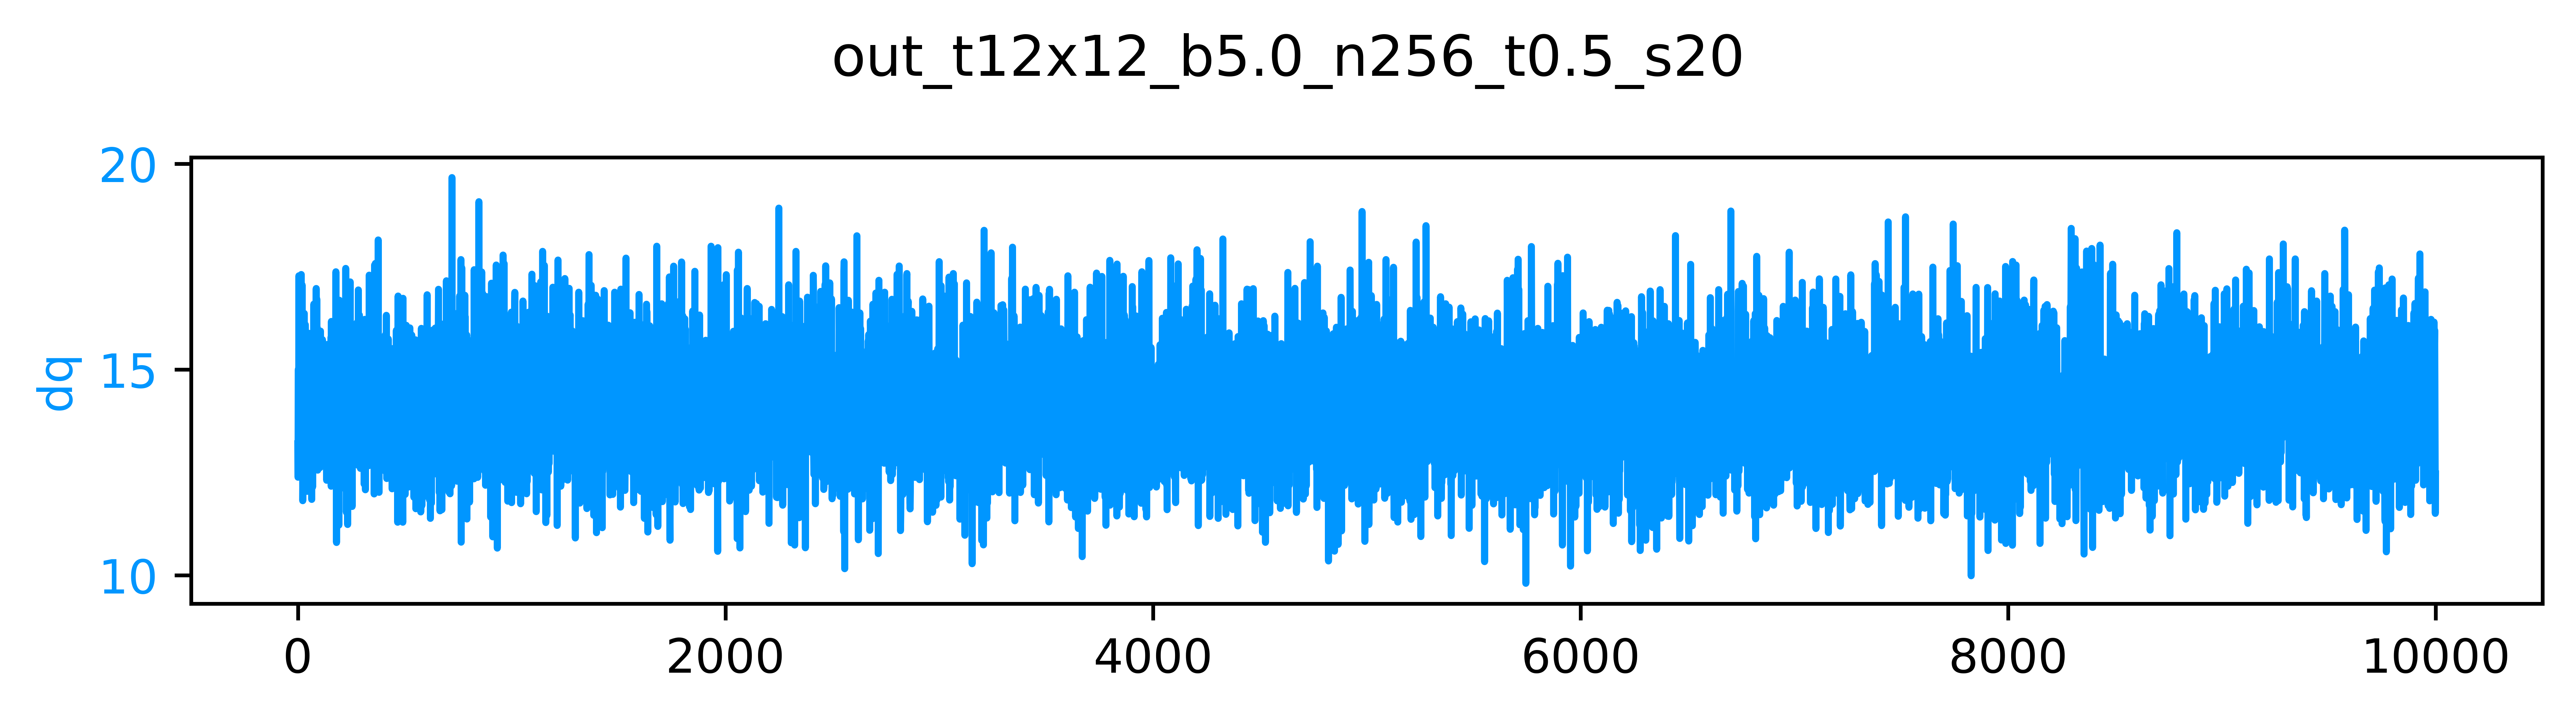

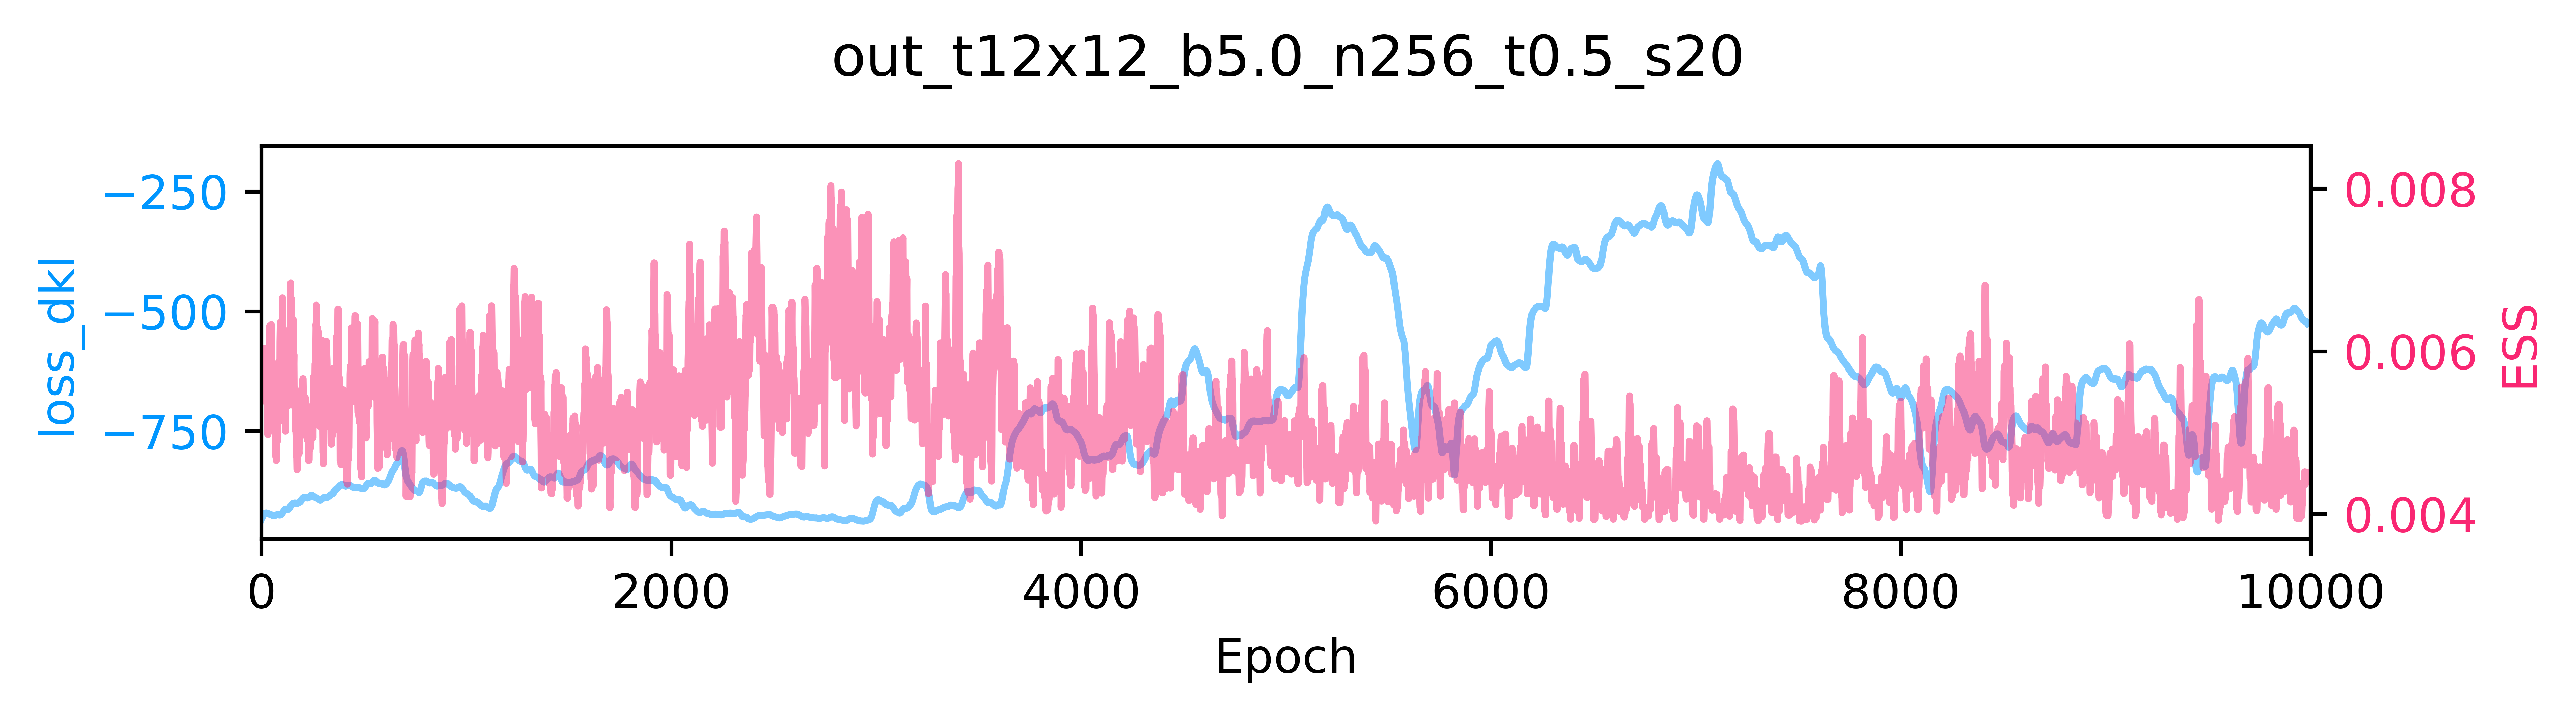

In [34]:
train_outputs12 = train(param12,
                        train_config12,
                        model=model12,
                        pre_model=None,
                        logger=logger,
                        figsize=(7.5, 2))

pre_flow_plots12 = train_outputs12['plots']
pre_flow_history12 = train_outputs12['history']
flow_act12 = train_outputs12['action']

pre_flow_model12 = train_outputs12['model']
pre_flow_optimizer12 = train_outputs12['optimizer_kdl']

# Save model, optimizer, and history to checkpoint
step12 = train_config12.n_era * train_config12.n_epoch

outfile12 = os.path.join(MODEL_DIR12, 'pre_flow_model', TSTAMP12, 'pre_flow_model.tar')
io.save_checkpoint(
    epoch=step12,
    outfile=outfile12,
    model=pre_flow_model12['layers'],
    optimizer=pre_flow_optimizer12,
    history=train_outputs12['history'],
    overwrite=True,
)

plots12 = train_outputs12['plots']
outdir12 = os.path.join(PLOTS_DIR12, 'training', 'pre_flow_model', TSTAMP12)

save_live_plots(plots12, outdir12)

TORCH DEVICE: cuda


TrainConfig(n_era=100, n_epoch=100, n_layers=32, n_s_nets=2, hidden_sizes=[8, 8], kernel_size=3, base_lr=0.001, batch_size=1024, print_freq=10, plot_freq=50, with_force=True)

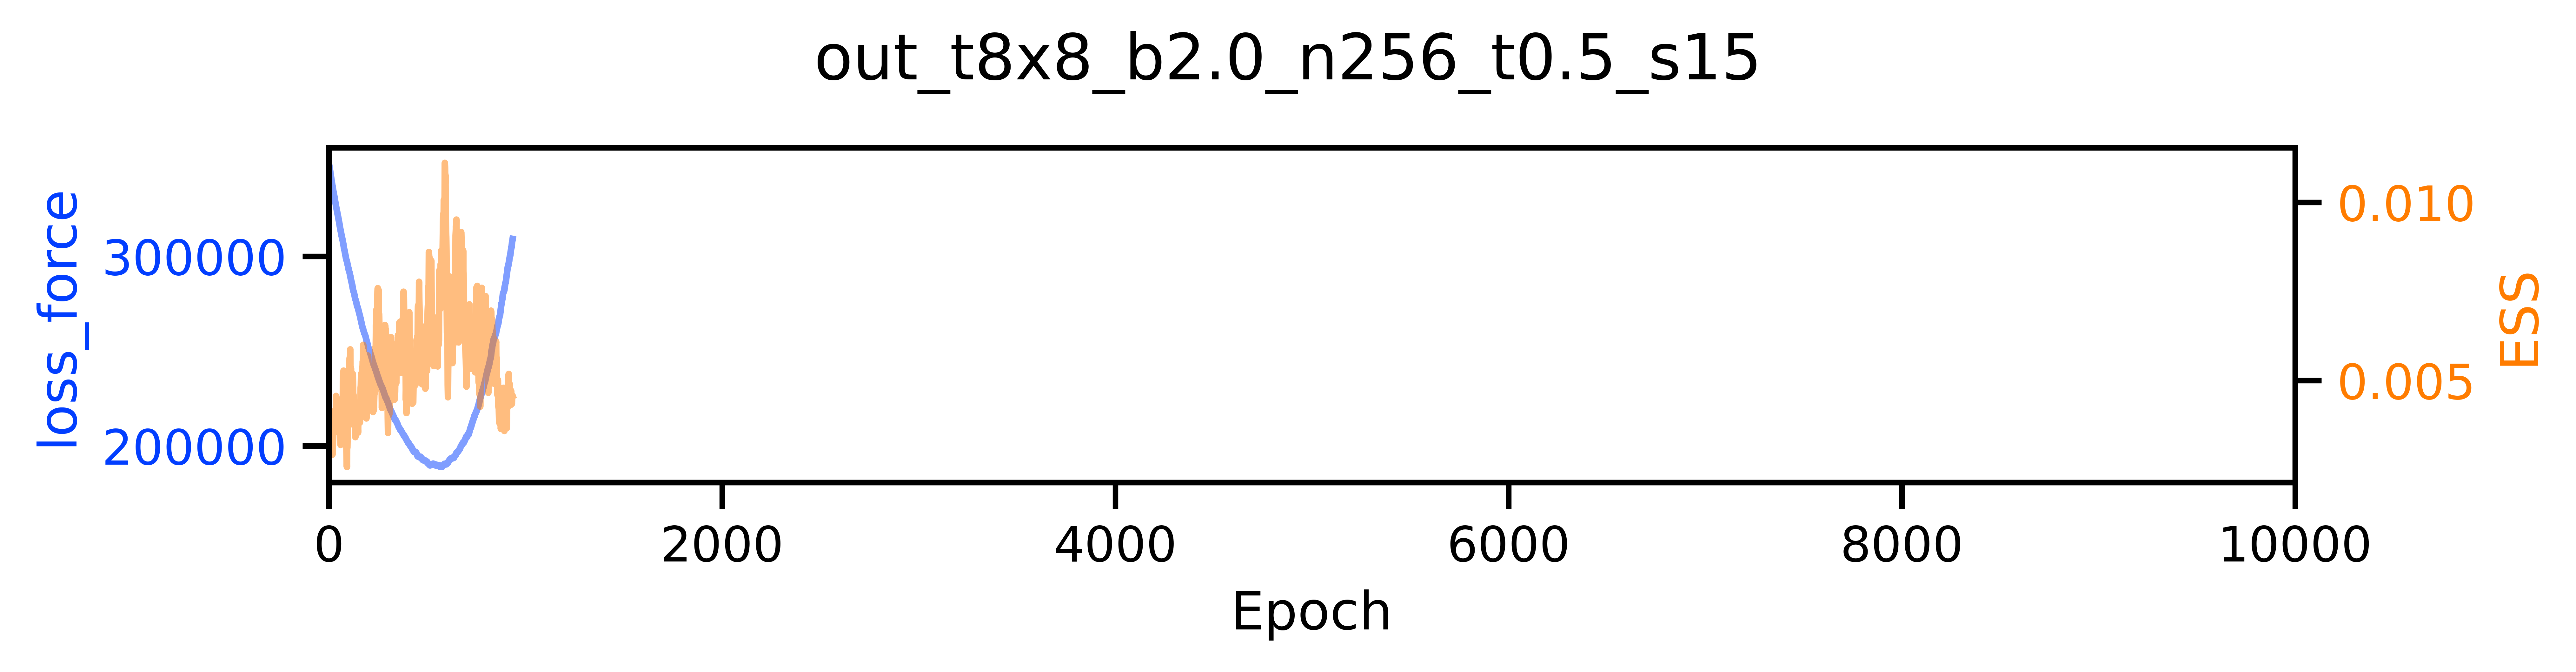

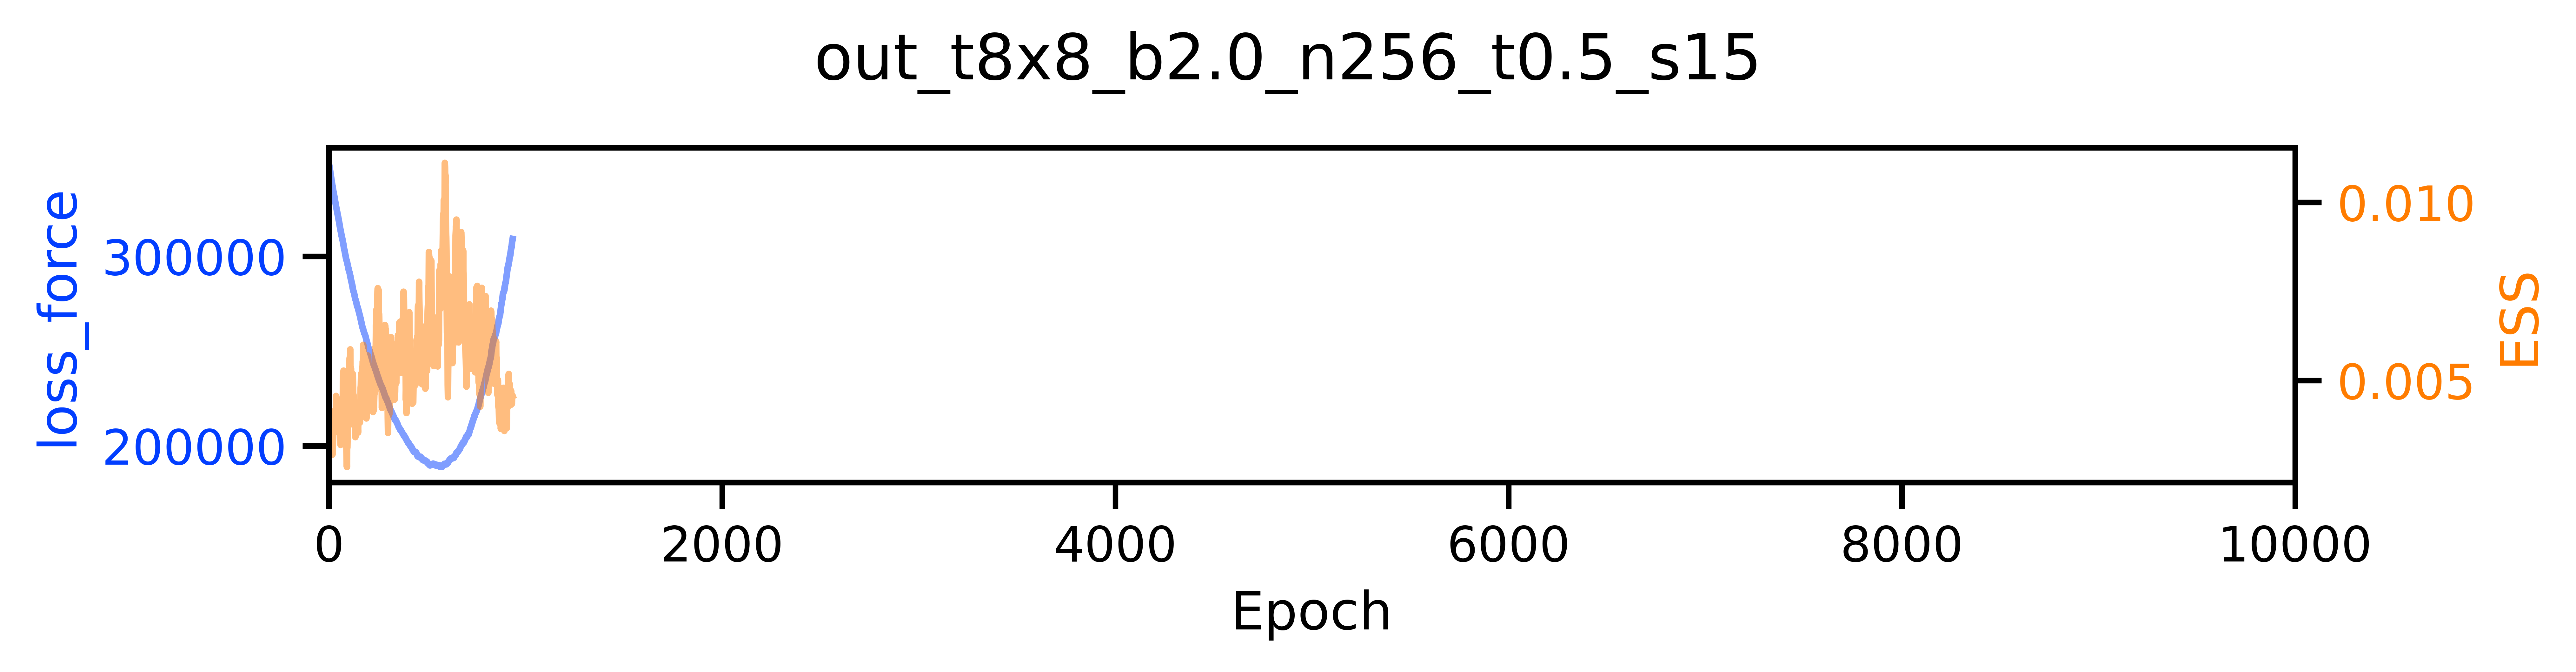

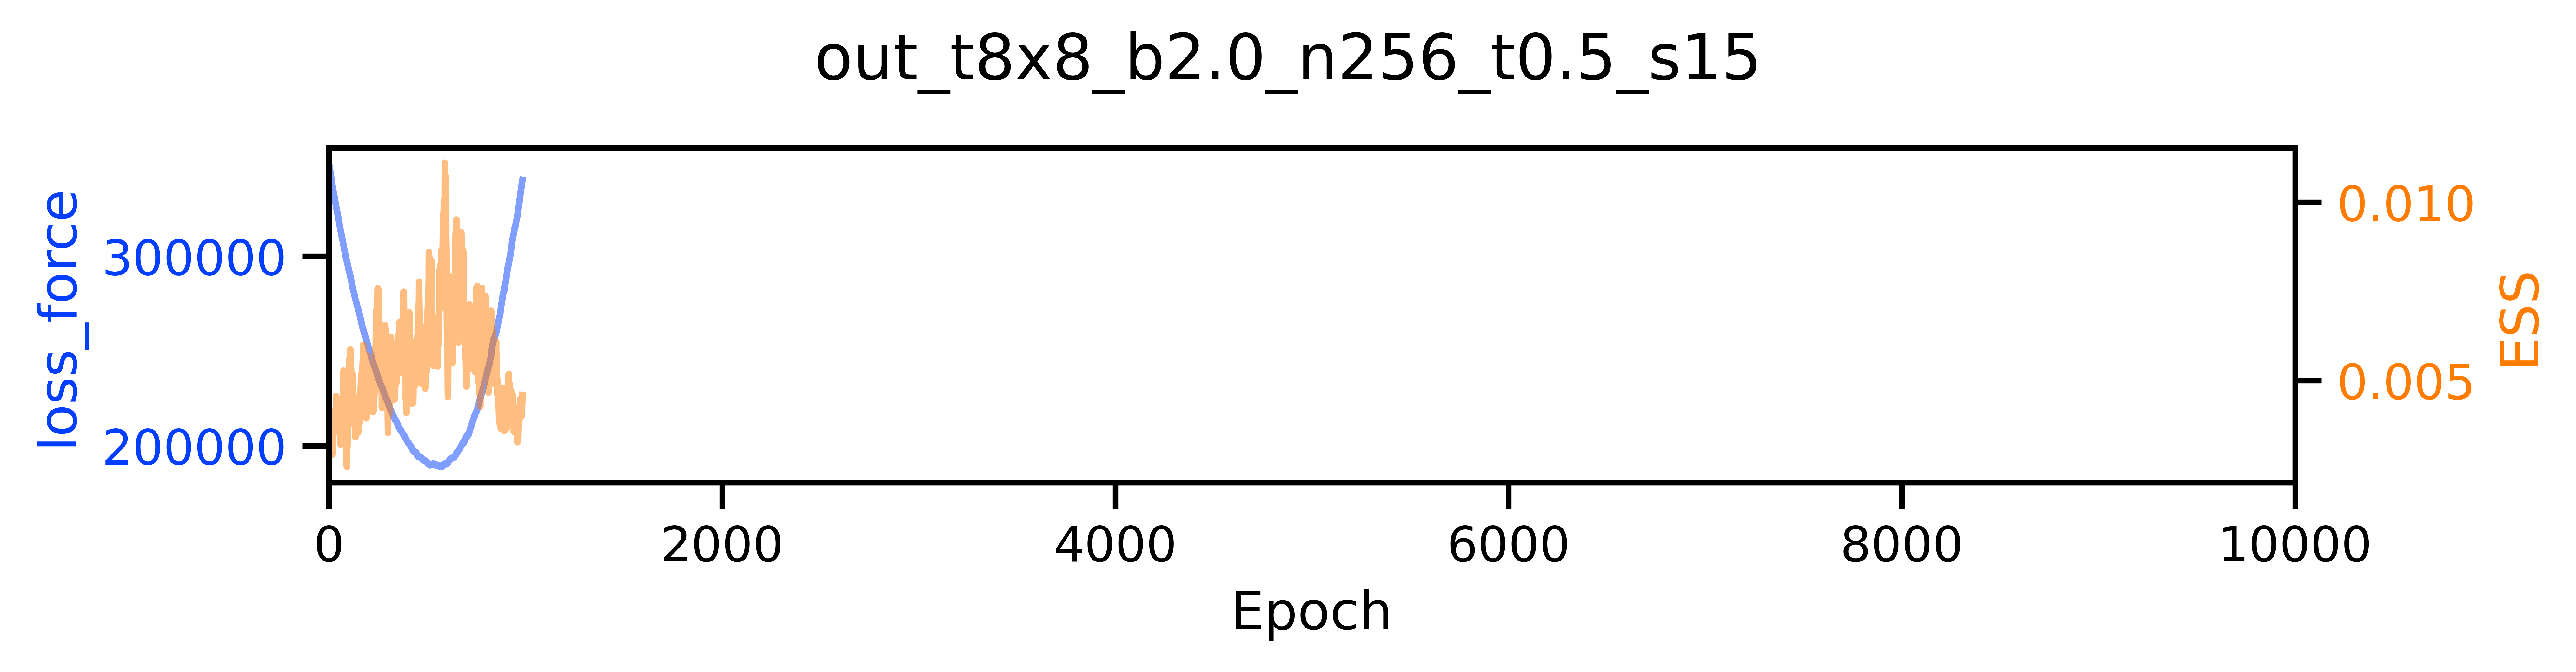

[13:59:55]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=0, last took: 0 min 0 s                                                                                                                                                                                                                         
            -------------------------------------------------------------------

[14:00:05]  epoch=7.000 dt=0.921 loss=349382.062 dq=0.170 ess=0.004 loss_dkl=0.000 logp=87.879 logq=-233.835 loss_force=349382.081 force_size=349382.062 force_norm=591.084

[14:00:15]  epoch=17.000 dt=0.918 loss=342618.562 dq=0.185 ess=0.004 loss_dkl=0.000 logp=87.827 logq=-233.471 loss_force=342618.556 force_size=342618.562 force_norm=585.334

[14:00:24]  epoch=27.000 dt=0.909 loss=335547.594 dq=0.173 ess=0.002 loss_dkl=0.000 logp=87.864 logq=-233.089 loss_force=335547.588 force_size=335547.594 force_norm=579.263

[14:00:33]  epoch=37.000 dt=0.918 loss=330418.812 dq=0.179 ess=0.006 loss_dkl=0.000 logp=88.006 logq=-232.717 loss_force=330418.812 force_size=330418.812 force_norm=574.820

[14:00:42]  epoch=47.000 dt=0.921 loss=325021.906 dq=0.184 ess=0.004 loss_dkl=0.000 logp=87.892 logq=-232.352 loss_force=325021.919 force_size=325021.906 force_norm=570.106

[14:00:54]  epoch=57.000 dt=0.919 loss=319582.062 dq=0.175 ess=0.005 loss_dkl=0.000 logp=87.619 logq=-232.025 loss_force=319582.069 force_size=319582.062 force_norm=565.314

[14:01:04]  epoch=67.000 dt=0.917 loss=312900.344 dq=0.192 ess=0.003 loss_dkl=0.000 logp=87.959 logq=-231.668 loss_force=312900.325 force_size=312900.344 force_norm=559.374

[14:01:13]  epoch=77.000 dt=0.917 loss=308271.500 dq=0.182 ess=0.006 loss_dkl=0.000 logp=88.000 logq=-231.302 loss_force=308271.494 force_size=308271.500 force_norm=555.219

[14:01:22]  epoch=87.000 dt=0.923 loss=302801.500 dq=0.181 ess=0.005 loss_dkl=0.000 logp=87.928 logq=-230.966 loss_force=302801.531 force_size=302801.500 force_norm=550.271

[14:01:31]  epoch=97.000 dt=0.921 loss=297788.656 dq=0.187 ess=0.002 loss_dkl=0.000 logp=87.973 logq=-230.636 loss_force=297788.644 force_size=297788.656 force_norm=545.699

[14:01:34]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=1, last took: 1 min 38.66 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:01:43]  epoch=7.000 dt=0.916 loss=293881.906 dq=0.191 ess=0.005 loss_dkl=0.000 logp=87.823 logq=-230.306 loss_force=293881.894 force_size=293881.906 force_norm=542.106

[14:01:53]  epoch=17.000 dt=0.922 loss=289758.938 dq=0.201 ess=0.004 loss_dkl=0.000 logp=87.725 logq=-229.992 loss_force=289758.938 force_size=289758.938 force_norm=538.291

[14:02:02]  epoch=27.000 dt=0.918 loss=283250.906 dq=0.198 ess=0.005 loss_dkl=0.000 logp=87.896 logq=-229.652 loss_force=283250.900 force_size=283250.906 force_norm=532.212

[14:02:11]  epoch=37.000 dt=0.919 loss=279002.062 dq=0.224 ess=0.004 loss_dkl=0.000 logp=87.818 logq=-229.334 loss_force=279002.044 force_size=279002.062 force_norm=528.206

[14:02:20]  epoch=47.000 dt=0.925 loss=275139.406 dq=0.226 ess=0.002 loss_dkl=0.000 logp=87.783 logq=-229.022 loss_force=275139.400 force_size=275139.406 force_norm=524.536

[14:02:32]  epoch=57.000 dt=0.925 loss=271364.625 dq=0.220 ess=0.004 loss_dkl=0.000 logp=87.911 logq=-228.693 loss_force=271364.650 force_size=271364.625 force_norm=520.926

[14:02:42]  epoch=67.000 dt=0.920 loss=267911.750 dq=0.213 ess=0.005 loss_dkl=0.000 logp=87.720 logq=-228.408 loss_force=267911.725 force_size=267911.750 force_norm=517.601

[14:02:51]  epoch=77.000 dt=0.921 loss=263966.656 dq=0.220 ess=0.006 loss_dkl=0.000 logp=87.844 logq=-228.072 loss_force=263966.628 force_size=263966.656 force_norm=513.774

[14:03:00]  epoch=87.000 dt=0.917 loss=260106.125 dq=0.236 ess=0.006 loss_dkl=0.000 logp=87.768 logq=-227.791 loss_force=260106.134 force_size=260106.125 force_norm=510.005

[14:03:09]  epoch=97.000 dt=0.915 loss=256895.906 dq=0.239 ess=0.003 loss_dkl=0.000 logp=87.761 logq=-227.481 loss_force=256895.891 force_size=256895.906 force_norm=506.847

[14:03:12]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=2, last took: 1 min 38.04 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:03:21]  epoch=7.000 dt=0.916 loss=252590.531 dq=0.234 ess=0.007 loss_dkl=0.000 logp=87.854 logq=-227.176 loss_force=252590.519 force_size=252590.531 force_norm=502.583

[14:03:31]  epoch=17.000 dt=0.916 loss=249466.250 dq=0.237 ess=0.004 loss_dkl=0.000 logp=87.855 logq=-226.882 loss_force=249466.247 force_size=249466.250 force_norm=499.463

[14:03:40]  epoch=27.000 dt=0.934 loss=245849.500 dq=0.242 ess=0.005 loss_dkl=0.000 logp=87.880 logq=-226.594 loss_force=245849.497 force_size=245849.500 force_norm=495.832

[14:03:49]  epoch=37.000 dt=0.941 loss=241978.219 dq=0.250 ess=0.004 loss_dkl=0.000 logp=87.771 logq=-226.296 loss_force=241978.222 force_size=241978.219 force_norm=491.912

[14:03:59]  epoch=47.000 dt=0.931 loss=239896.594 dq=0.267 ess=0.005 loss_dkl=0.000 logp=87.867 logq=-226.013 loss_force=239896.594 force_size=239896.594 force_norm=489.792

[14:04:11]  epoch=57.000 dt=0.929 loss=236458.672 dq=0.266 ess=0.007 loss_dkl=0.000 logp=87.933 logq=-225.733 loss_force=236458.669 force_size=236458.672 force_norm=486.268

[14:04:20]  epoch=67.000 dt=0.926 loss=233440.750 dq=0.283 ess=0.007 loss_dkl=0.000 logp=87.730 logq=-225.470 loss_force=233440.747 force_size=233440.750 force_norm=483.154

[14:04:29]  epoch=77.000 dt=0.938 loss=231496.125 dq=0.288 ess=0.005 loss_dkl=0.000 logp=87.817 logq=-225.185 loss_force=231496.138 force_size=231496.125 force_norm=481.139

[14:04:39]  epoch=87.000 dt=0.923 loss=228385.844 dq=0.289 ess=0.005 loss_dkl=0.000 logp=87.827 logq=-224.920 loss_force=228385.844 force_size=228385.844 force_norm=477.893

[14:04:48]  epoch=97.000 dt=0.920 loss=224627.422 dq=0.296 ess=0.007 loss_dkl=0.000 logp=87.823 logq=-224.624 loss_force=224627.419 force_size=224627.422 force_norm=473.947

[14:04:51]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=3, last took: 1 min 38.57 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:05:00]  epoch=7.000 dt=0.923 loss=223681.500 dq=0.293 ess=0.006 loss_dkl=0.000 logp=87.768 logq=-224.371 loss_force=223681.513 force_size=223681.500 force_norm=472.943

[14:05:09]  epoch=17.000 dt=0.917 loss=220285.281 dq=0.317 ess=0.007 loss_dkl=0.000 logp=87.759 logq=-224.120 loss_force=220285.284 force_size=220285.281 force_norm=469.344

[14:05:18]  epoch=27.000 dt=0.923 loss=217805.969 dq=0.330 ess=0.006 loss_dkl=0.000 logp=87.760 logq=-223.862 loss_force=217805.981 force_size=217805.969 force_norm=466.696

[14:05:28]  epoch=37.000 dt=0.917 loss=214853.875 dq=0.321 ess=0.005 loss_dkl=0.000 logp=87.969 logq=-223.547 loss_force=214853.878 force_size=214853.875 force_norm=463.520

[14:05:37]  epoch=47.000 dt=0.925 loss=213638.578 dq=0.340 ess=0.005 loss_dkl=0.000 logp=87.808 logq=-223.340 loss_force=213638.575 force_size=213638.578 force_norm=462.210

[14:05:49]  epoch=57.000 dt=0.939 loss=210256.344 dq=0.334 ess=0.004 loss_dkl=0.000 logp=88.008 logq=-223.047 loss_force=210256.341 force_size=210256.344 force_norm=458.537

[14:05:58]  epoch=67.000 dt=0.920 loss=209659.703 dq=0.366 ess=0.007 loss_dkl=0.000 logp=87.786 logq=-222.845 loss_force=209659.700 force_size=209659.703 force_norm=457.885

[14:06:08]  epoch=77.000 dt=0.925 loss=207670.125 dq=0.362 ess=0.006 loss_dkl=0.000 logp=87.796 logq=-222.596 loss_force=207670.116 force_size=207670.125 force_norm=455.707

[14:06:17]  epoch=87.000 dt=0.926 loss=205492.922 dq=0.374 ess=0.005 loss_dkl=0.000 logp=87.805 logq=-222.349 loss_force=205492.925 force_size=205492.922 force_norm=453.311

[14:06:26]  epoch=97.000 dt=0.925 loss=204436.375 dq=0.388 ess=0.002 loss_dkl=0.000 logp=87.810 logq=-222.129 loss_force=204436.381 force_size=204436.375 force_norm=452.141

[14:06:29]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=4, last took: 1 min 38.66 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:06:39]  epoch=7.000 dt=0.922 loss=201549.750 dq=0.392 ess=0.005 loss_dkl=0.000 logp=88.000 logq=-221.850 loss_force=201549.750 force_size=201549.750 force_norm=448.942

[14:06:48]  epoch=17.000 dt=0.926 loss=200807.328 dq=0.428 ess=0.007 loss_dkl=0.000 logp=87.855 logq=-221.653 loss_force=200807.331 force_size=200807.328 force_norm=448.112

[14:06:57]  epoch=27.000 dt=0.917 loss=199045.453 dq=0.449 ess=0.006 loss_dkl=0.000 logp=87.776 logq=-221.447 loss_force=199045.462 force_size=199045.453 force_norm=446.139

[14:07:07]  epoch=37.000 dt=0.919 loss=196275.000 dq=0.431 ess=0.007 loss_dkl=0.000 logp=88.069 logq=-221.148 loss_force=196274.987 force_size=196275.000 force_norm=443.027

[14:07:16]  epoch=47.000 dt=0.925 loss=197015.484 dq=0.468 ess=0.005 loss_dkl=0.000 logp=87.830 logq=-220.986 loss_force=197015.487 force_size=197015.484 force_norm=443.861

[14:07:28]  epoch=57.000 dt=0.916 loss=194583.312 dq=0.469 ess=0.006 loss_dkl=0.000 logp=87.991 logq=-220.721 loss_force=194583.303 force_size=194583.312 force_norm=441.116

[14:07:37]  epoch=67.000 dt=0.948 loss=194710.281 dq=0.510 ess=0.006 loss_dkl=0.000 logp=87.648 logq=-220.608 loss_force=194710.281 force_size=194710.281 force_norm=441.255

[14:07:47]  epoch=77.000 dt=0.928 loss=192931.703 dq=0.499 ess=0.004 loss_dkl=0.000 logp=87.887 logq=-220.364 loss_force=192931.706 force_size=192931.703 force_norm=439.239

[14:07:56]  epoch=87.000 dt=0.937 loss=192453.906 dq=0.533 ess=0.008 loss_dkl=0.000 logp=87.702 logq=-220.150 loss_force=192453.888 force_size=192453.906 force_norm=438.693

[14:08:06]  epoch=97.000 dt=0.927 loss=191742.609 dq=0.553 ess=0.006 loss_dkl=0.000 logp=87.870 logq=-219.955 loss_force=191742.606 force_size=191742.609 force_norm=437.883

[14:08:08]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=5, last took: 1 min 38.89 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:08:17]  epoch=7.000 dt=0.922 loss=191572.875 dq=0.596 ess=0.006 loss_dkl=0.000 logp=87.974 logq=-219.738 loss_force=191572.891 force_size=191572.875 force_norm=437.687

[14:08:27]  epoch=17.000 dt=0.938 loss=188759.875 dq=0.615 ess=0.005 loss_dkl=0.000 logp=87.971 logq=-219.539 loss_force=188759.872 force_size=188759.875 force_norm=434.464

[14:08:36]  epoch=27.000 dt=0.922 loss=190404.219 dq=0.640 ess=0.006 loss_dkl=0.000 logp=87.855 logq=-219.415 loss_force=190404.237 force_size=190404.219 force_norm=436.351

[14:08:46]  epoch=37.000 dt=0.926 loss=190117.359 dq=0.667 ess=0.006 loss_dkl=0.000 logp=87.840 logq=-219.256 loss_force=190117.356 force_size=190117.359 force_norm=436.022

[14:08:55]  epoch=47.000 dt=0.929 loss=189893.156 dq=0.675 ess=0.008 loss_dkl=0.000 logp=87.854 logq=-219.088 loss_force=189893.138 force_size=189893.156 force_norm=435.762

[14:09:07]  epoch=57.000 dt=0.922 loss=189959.328 dq=0.687 ess=0.006 loss_dkl=0.000 logp=87.882 logq=-218.947 loss_force=189959.316 force_size=189959.328 force_norm=435.843

[14:09:17]  epoch=67.000 dt=0.933 loss=189351.094 dq=0.775 ess=0.008 loss_dkl=0.000 logp=87.941 logq=-218.777 loss_force=189351.087 force_size=189351.094 force_norm=435.144

[14:09:26]  epoch=77.000 dt=0.925 loss=188289.188 dq=0.765 ess=0.009 loss_dkl=0.000 logp=87.942 logq=-218.588 loss_force=188289.191 force_size=188289.188 force_norm=433.913

[14:09:35]  epoch=87.000 dt=0.936 loss=189466.781 dq=0.851 ess=0.009 loss_dkl=0.000 logp=87.857 logq=-218.498 loss_force=189466.794 force_size=189466.781 force_norm=435.267

[14:09:45]  epoch=97.000 dt=0.935 loss=191083.781 dq=0.864 ess=0.011 loss_dkl=0.000 logp=87.743 logq=-218.430 loss_force=191083.766 force_size=191083.781 force_norm=437.131

[14:09:47]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=6, last took: 1 min 39.31 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:09:57]  epoch=7.000 dt=0.942 loss=190629.469 dq=0.919 ess=0.006 loss_dkl=0.000 logp=87.885 logq=-218.254 loss_force=190629.478 force_size=190629.469 force_norm=436.608

[14:10:06]  epoch=17.000 dt=0.937 loss=191891.094 dq=0.942 ess=0.006 loss_dkl=0.000 logp=87.862 logq=-218.170 loss_force=191891.084 force_size=191891.094 force_norm=438.049

[14:10:16]  epoch=27.000 dt=0.930 loss=193129.188 dq=1.004 ess=0.008 loss_dkl=0.000 logp=87.780 logq=-218.088 loss_force=193129.184 force_size=193129.188 force_norm=439.459

[14:10:25]  epoch=37.000 dt=0.924 loss=192908.656 dq=1.076 ess=0.008 loss_dkl=0.000 logp=87.845 logq=-217.964 loss_force=192908.672 force_size=192908.656 force_norm=439.210

[14:10:35]  epoch=47.000 dt=0.950 loss=193288.781 dq=1.116 ess=0.007 loss_dkl=0.000 logp=87.905 logq=-217.804 loss_force=193288.775 force_size=193288.781 force_norm=439.642

[14:10:47]  epoch=57.000 dt=0.921 loss=195993.531 dq=1.186 ess=0.015 loss_dkl=0.000 logp=87.822 logq=-217.798 loss_force=195993.544 force_size=195993.531 force_norm=442.708

[14:10:56]  epoch=67.000 dt=0.926 loss=196636.000 dq=1.203 ess=0.004 loss_dkl=0.000 logp=87.854 logq=-217.689 loss_force=196636.000 force_size=196636.000 force_norm=443.434

[14:11:05]  epoch=77.000 dt=0.926 loss=199392.766 dq=1.329 ess=0.009 loss_dkl=0.000 logp=87.792 logq=-217.659 loss_force=199392.759 force_size=199392.766 force_norm=446.531

[14:11:15]  epoch=87.000 dt=0.920 loss=201355.156 dq=1.371 ess=0.009 loss_dkl=0.000 logp=87.778 logq=-217.637 loss_force=201355.163 force_size=201355.156 force_norm=448.725

[14:11:24]  epoch=97.000 dt=0.919 loss=201640.859 dq=1.540 ess=0.008 loss_dkl=0.000 logp=87.942 logq=-217.510 loss_force=201640.859 force_size=201640.859 force_norm=449.037

[14:11:27]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=7, last took: 1 min 39.11 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:11:36]  epoch=7.000 dt=0.922 loss=205536.266 dq=1.604 ess=0.004 loss_dkl=0.000 logp=87.775 logq=-217.516 loss_force=205536.256 force_size=205536.266 force_norm=453.355

[14:11:45]  epoch=17.000 dt=0.925 loss=205960.453 dq=1.735 ess=0.010 loss_dkl=0.000 logp=87.939 logq=-217.413 loss_force=205960.453 force_size=205960.453 force_norm=453.802

[14:11:55]  epoch=27.000 dt=0.931 loss=209305.688 dq=1.881 ess=0.006 loss_dkl=0.000 logp=87.875 logq=-217.397 loss_force=209305.697 force_size=209305.688 force_norm=457.492

[14:12:04]  epoch=37.000 dt=0.925 loss=211053.406 dq=1.892 ess=0.005 loss_dkl=0.000 logp=87.923 logq=-217.440 loss_force=211053.400 force_size=211053.406 force_norm=459.401

[14:12:13]  epoch=47.000 dt=0.921 loss=215909.172 dq=2.033 ess=0.006 loss_dkl=0.000 logp=87.792 logq=-217.490 loss_force=215909.175 force_size=215909.172 force_norm=464.655

[14:12:25]  epoch=57.000 dt=0.931 loss=217781.297 dq=2.109 ess=0.005 loss_dkl=0.000 logp=87.906 logq=-217.498 loss_force=217781.294 force_size=217781.297 force_norm=466.660

[14:12:35]  epoch=67.000 dt=0.937 loss=220280.406 dq=2.265 ess=0.006 loss_dkl=0.000 logp=88.022 logq=-217.518 loss_force=220280.378 force_size=220280.406 force_norm=469.332

[14:12:44]  epoch=77.000 dt=0.935 loss=225510.047 dq=2.505 ess=0.006 loss_dkl=0.000 logp=87.762 logq=-217.556 loss_force=225510.062 force_size=225510.047 force_norm=474.862

[14:12:54]  epoch=87.000 dt=0.933 loss=227618.406 dq=2.657 ess=0.008 loss_dkl=0.000 logp=87.808 logq=-217.656 loss_force=227618.406 force_size=227618.406 force_norm=477.088

[14:13:03]  epoch=97.000 dt=0.937 loss=233135.078 dq=2.854 ess=0.005 loss_dkl=0.000 logp=87.780 logq=-217.669 loss_force=233135.075 force_size=233135.078 force_norm=482.834

[14:13:06]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=8, last took: 1 min 39.36 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:13:16]  epoch=7.000 dt=0.947 loss=236182.047 dq=2.981 ess=0.009 loss_dkl=0.000 logp=87.833 logq=-217.797 loss_force=236182.069 force_size=236182.047 force_norm=485.983

[14:13:25]  epoch=17.000 dt=0.943 loss=239802.297 dq=3.205 ess=0.004 loss_dkl=0.000 logp=87.877 logq=-217.840 loss_force=239802.316 force_size=239802.297 force_norm=489.689

[14:13:35]  epoch=27.000 dt=0.952 loss=243964.578 dq=3.340 ess=0.005 loss_dkl=0.000 logp=87.996 logq=-217.924 loss_force=243964.566 force_size=243964.578 force_norm=493.909

[14:13:44]  epoch=37.000 dt=0.941 loss=250139.781 dq=3.666 ess=0.009 loss_dkl=0.000 logp=87.859 logq=-218.064 loss_force=250139.772 force_size=250139.781 force_norm=500.127

[14:13:54]  epoch=47.000 dt=0.935 loss=257501.578 dq=3.939 ess=0.003 loss_dkl=0.000 logp=87.857 logq=-218.235 loss_force=257501.566 force_size=257501.578 force_norm=507.440

[14:14:06]  epoch=57.000 dt=0.943 loss=259806.422 dq=4.185 ess=0.004 loss_dkl=0.000 logp=87.863 logq=-218.307 loss_force=259806.419 force_size=259806.422 force_norm=509.689

[14:14:15]  epoch=67.000 dt=0.939 loss=265401.875 dq=4.630 ess=0.004 loss_dkl=0.000 logp=87.947 logq=-218.420 loss_force=265401.881 force_size=265401.875 force_norm=515.169

[14:14:25]  epoch=77.000 dt=0.929 loss=269149.531 dq=4.803 ess=0.004 loss_dkl=0.000 logp=87.898 logq=-218.569 loss_force=269149.531 force_size=269149.531 force_norm=518.787

[14:14:34]  epoch=87.000 dt=0.931 loss=277336.844 dq=5.102 ess=0.004 loss_dkl=0.000 logp=87.815 logq=-218.762 loss_force=277336.856 force_size=277336.844 force_norm=526.615

[14:14:44]  epoch=97.000 dt=0.926 loss=283709.562 dq=5.382 ess=0.003 loss_dkl=0.000 logp=87.848 logq=-218.911 loss_force=283709.562 force_size=283709.562 force_norm=532.635

[14:14:46]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=9, last took: 1 min 40.39 s                                                                                                                                                                                                                     
            -------------------------------------------------------------------

[14:14:56]  epoch=7.000 dt=0.935 loss=285669.438 dq=5.824 ess=0.003 loss_dkl=0.000 logp=87.934 logq=-219.052 loss_force=285669.431 force_size=285669.438 force_norm=534.469

[14:15:05]  epoch=17.000 dt=0.943 loss=293721.562 dq=6.134 ess=0.005 loss_dkl=0.000 logp=87.810 logq=-219.229 loss_force=293721.544 force_size=293721.562 force_norm=541.958

[14:15:15]  epoch=27.000 dt=0.930 loss=297774.844 dq=6.368 ess=0.005 loss_dkl=0.000 logp=87.792 logq=-219.463 loss_force=297774.850 force_size=297774.844 force_norm=545.679

[14:15:24]  epoch=37.000 dt=0.941 loss=306798.812 dq=6.906 ess=0.004 loss_dkl=0.000 logp=87.724 logq=-219.667 loss_force=306798.787 force_size=306798.812 force_norm=553.871

[14:15:34]  epoch=47.000 dt=0.938 loss=313975.125 dq=7.323 ess=0.004 loss_dkl=0.000 logp=87.735 logq=-219.912 loss_force=313975.144 force_size=313975.125 force_norm=560.329

[14:15:46]  epoch=57.000 dt=0.942 loss=316753.250 dq=7.364 ess=0.004 loss_dkl=0.000 logp=87.995 logq=-220.034 loss_force=316753.269 force_size=316753.250 force_norm=562.805

[14:15:56]  epoch=67.000 dt=0.950 loss=321251.625 dq=7.780 ess=0.003 loss_dkl=0.000 logp=87.877 logq=-220.195 loss_force=321251.619 force_size=321251.625 force_norm=566.789

[14:16:05]  epoch=77.000 dt=0.937 loss=330103.312 dq=8.314 ess=0.005 loss_dkl=0.000 logp=87.788 logq=-220.461 loss_force=330103.325 force_size=330103.312 force_norm=574.531

[14:16:15]  epoch=87.000 dt=0.938 loss=337821.812 dq=8.716 ess=0.005 loss_dkl=0.000 logp=87.909 logq=-220.606 loss_force=337821.794 force_size=337821.812 force_norm=581.211

[14:16:25]  epoch=97.000 dt=0.949 loss=343318.375 dq=9.343 ess=0.005 loss_dkl=0.000 logp=87.718 logq=-220.919 loss_force=343318.375 force_size=343318.375 force_norm=585.924

[14:16:27]  -------------------------------------------------------------------                                                                                                                                                                                 
            ERA=10, last took: 1 min 40.83 s                                                                                                                                                                                                                    
            -------------------------------------------------------------------

[14:16:37]  epoch=7.000 dt=0.951 loss=348071.156 dq=9.435 ess=0.007 loss_dkl=0.000 logp=87.687 logq=-221.123 loss_force=348071.144 force_size=348071.156 force_norm=589.968

[14:16:46]  epoch=17.000 dt=0.944 loss=357047.250 dq=9.986 ess=0.006 loss_dkl=0.000 logp=87.706 logq=-221.390 loss_force=357047.244 force_size=357047.250 force_norm=597.528

[14:16:56]  epoch=27.000 dt=0.929 loss=357202.562 dq=10.028 ess=0.003 loss_dkl=0.000 logp=87.912 logq=-221.442 loss_force=357202.562 force_size=357202.562 force_norm=597.646

[14:17:05]  epoch=37.000 dt=0.934 loss=364697.812 dq=10.674 ess=0.004 loss_dkl=0.000 logp=87.877 logq=-221.670 loss_force=364697.775 force_size=364697.812 force_norm=603.899

In [ ]:
import seaborn as sns

from dataclasses import asdict
from copy import deepcopy
from utils.distributions import MultivariateUniform
from utils.layers import make_u1_equiv_layers, set_weights
from math import pi as PI
import utils.qed_helpers as qed

TWO_PI = 2 * PI
# from train import train

sns.set_context('notebook')
sns.set_palette('bright')

train_cfg_force = asdict(train_config)
train_cfg_force['with_force'] = True

tconfig_force = TrainConfig(**train_cfg_force)

link_shape = (2, *param.lat)
lattice_shape = tuple(param.lat)
u1_action = qed.BatchAction(param.beta)

prior = MultivariateUniform(torch.zeros(link_shape),
                            TWO_PI * torch.ones(link_shape))

tconfig_force
layers = make_u1_equiv_layers(lattice_shape=lattice_shape,
                              n_layers=tconfig_force.n_layers,
                              n_mixture_comps=tconfig_force.n_s_nets,
                              hidden_sizes=tconfig_force.hidden_sizes,
                              kernel_size=tconfig_force.kernel_size)

set_weights(layers)

model_force = {
    'prior': prior,
    'layers': layers,
}
                              

outputs = train(param, tconfig_force,
                model=model_force,
                pre_model=pre_flow_model,
                figsize=(8, 2.),
                use_alt=False,
                force_factor=0.001,
                dkl_factor=1.)#, logger=logger)

flow_model_force = outputs['model']
flow_model_force_history = outputs['history']
flow_action_force = outputs['action']

In [ ]:
def test_force(
    param: Param,
    model: dict,
    x: torch.Tensor = None,
    pre_model: dict = None
):
    """Test the force.
    
    If `x` is None:
      - Draw samples `xi (~ pre_prior)` from prior and pass through `pre_model` to get `x (~ pre_posterior)`.
     
    Pass `x` backwards through the `model` to get `xi (~ prior)`.
    
    Calculate `force(xi)` and `norm(force(xi))`.
    """
    if x is None:
        if pre_model is None:
            raise ValueError(f'Either `x` or `pre_model` must be specified.')
            
        # Draw samples `xi` from prior
        pre_xi = pre_model['prior'].sample_n(1)
        
        # Pass `xi` through layers in `pre_model`
        x = qed.ft_flow(pre_model['layers'], pre_xi)
        
    # Pass `x` backwards through layers in `model`
    xi = qed.ft_flow_inv(model['layers'], x)
    # Calculate force
    force = qed.ft_force(param, model['layers'], xi)
    force_norm = torch.linalg.norm(force)
    return force_norm

In [ ]:
from train import run as hmc_run
fields, metrics = hmc_run(param, logger=logger, keep_fields=True)

#metrics_dir = os.path.join(OUTDIR, 'metrics', 'hmc')
#metrics_file = os.path.join(metrics_dir, 'metrics.z')
#io.savez(metrics, metrics_file)

In [ ]:
#field_arr = torch.stack(tuple(fields.values()), dim=0)
len(fields)
#
field_arr = np.array([qed.grab(torch.stack(i)) for i in fields])
field_arr.shape
#logger.log(field_arr.shape)

In [ ]:
for field in field_arr:
    force_tf = test_force(param, flow_model_force, pre_model=pre_flow_model)
    logger.log(f'ft_flow(players, pxi), (pxi ~ pre_prior): {force_tf:.5g}') 
    
    x = torch.from_numpy(field[-1]).squeeze()[None, :]
    if torch.cuda.is_available():
        x = x.cuda()
    
    #x_ = field_arr.squeeze()[None, :]
    force_ = test_force(param, flow_model_force, x=x, pre_model=pre_flow_model)
    logger.log(f'ft_flow(layers, field_arr), (pxi ~ pre_prior): {force_:.5g}')

In [ ]:
# field_arr generated from generic HMC run
for idx, fields in enumerate(field_arr):
    # x generated from HMC
    x = torch.from_numpy(fields)
    if torch.cuda.is_available():
        x = x.cuda()
        
    # flow HMC samples backwards through `flow_model_force` and calculate force
    force1 = test_force(param, flow_model_force, x=x)
    
    # sample x ~ pre_flow_model_prior, flow through `pre_flow_model` to get xi 
    # flow xi backwards through `flow_model_force` and calculate force
    force2 = test_force(param, flow_model_force, pre_model=pre_flow_model)
    
    logger.log(f'run={idx}\n'
               f'  (xi ~ HMC): force_xi={force1:.5g}\n'
               f"  (xi ~ pre_flow_model_prior): force_xi_pre={force2:.5g}")

In [ ]:
#field_run = torch.stack(tuple(fields.values()), dim=0)
##flows = flow

#x0 = field_arr[0][None, :]
#x = field_arr[0][None, :]

# select last trajectory from last run
x = torch.from_numpy(field_arr[-1][-1][None, :]).cuda()
x0 = torch.from_numpy(field_arr[-1][-1][None, :]).cuda()

if torch.cuda.is_available():
    x = x.cuda()

plaq0 = qed.action(param, x) / (-param.beta * param.volume)
logger.log(f'plaq(field_arr[0])={plaq0:.8g}')

#logger\.log(f'plaq(field_run[0]) {qed.action(param, x) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
#x = field_run[0][None, :]
logJ = 0.0
for layer in reversed(flow_model_force['layers']):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flow_model_force['layers']:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = qed.action(param, y[0][None, :]) - logJy

logger.log(f'sum(logJ): {qed.grab(logJ.sum())}')
logger.log(f'sum(logJy): {qed.grab(logJy.sum())}')
#print(logJ,logJy)


# print("eff_action", s + 136.3786)

logger.log(f'original_action: {qed.action(param, y[0][None, :]) + 91}')
#print("original_action", qed.action(param, y[0][None, :]) + 91)

logger.log(f'eff_action: {s + 56}')
#print("eff_action", {s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

logger.log(f'plaq(x) {qed.action(param, x[0][None, :]) / (-param.beta*param.volume)}  logJ {qed.grab(logJ)}  force.norm {torch.linalg.norm(f)}')
logger.log(f'plaq(y) {qed.action(param, y[0][None, :]) / (-param.beta*param.volume)}')
logger.log(f'plaq(x) {qed.action(param, x0) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(qed.force(param, x0))}')

In [ ]:
logger.log(x.shape)

field_tensor = torch.from_numpy(field_arr).cuda()

x = qed.ft_flow_inv(flow, field_tensor[-1])
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(ff))
fff = qed.ft_force(param, flow, x)
logger.log(torch.linalg.norm(fff))

In [ ]:
x = qed.ft_flow_inv(flow, field_tensor[-1])
logger.log(qed.grab(qed.ft_action(param, flow, x)))